<a href="https://colab.research.google.com/github/Tomokki/private_Python-.gitkeep/blob/main/Kishika_%E3%82%B3%E3%83%B3%E3%83%9A%E6%B5%81%E3%82%8C%E5%86%85%E5%AE%B9%E7%A2%BA%E8%AA%8D%E2%91%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

不動産価格予測

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 『cpt-house-2024wi』フォルダをGoogleDriveに作成して↓に記載されている通りにダウンロードデータを作成

In [ ]:
# GoogleDriveと接続してファイル共有

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna japanize-matplotlib > /dev/null
#日本語化モジュールをインストール
#optuna：

In [ ]:
# ご自身のパスを設定
YOUR_PATH = "/content/drive/MyDrive/cpt-house-2024wi"

In [ ]:
cd {YOUR_PATH}

/content/drive/MyDrive/cpt-house-2024wi


In [ ]:
import re #reモジュールをインポート

import japanize_matplotlib
import lightgbm as lgb #分析アルゴリズム
import matplotlib.pyplot as plt
import numpy as np
import optuna#ハイパーパラメータの最適化
import pandas as pd
import seaborn as sns #eabornはMatplotlibの機能をより美しく、より簡単に実現するための可視化ライブラリ
sns.set(font="IPAexGothic")

from glob import glob #指定したディレクトリ（フォルダ）の中にある、ファイルやサブディレクトリのリストを取得するための関数
from functools import partial #ある関数を操作したり、またそれによって新たな関数を取得したりできる関数をまとめたモジュール
from itertools import product
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OrdinalEncoder

## 実行環境の情報

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


メモリサイズ(GB)

In [ ]:
!cat /proc/meminfo | awk '($1=="MemTotal:") {print $2/1048576}'

12.6748


Pythonバージョン

In [ ]:
!python -V

Python 3.10.12


Pythonライブラリ情報

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
alembic==1.13.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.0.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.1
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlog==6.8.2
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.5
cuffli

## 前処理

文字列が特定の値の場合には、その値を整数に変換

- もし `moyori` が `'30分?60分'` の場合、`moyori` は `45` に変換。
- もし `moyori` が `'1H?1H30'` の場合、`moyori` は `75` に変換。
- もし `moyori` が `'1H30?2H'` の場合、`moyori` は `105` に変換。
- もし `moyori` が `'2H?'` の場合、`moyori` は `120` に変換。

* その後、 `moyori` を `int(float(moyori))` に変換。
* これは、もし `moyori` が文字列であれば、それを浮動小数点数に変換し、それから整数に変換。これにより、数値で表された `moyori` が文字列として与えられた場合でも、整数に変換。


In [ ]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

`area` を整数に変換  
正規表現を使用して、文字列から特定のパターンを削除

- もし `area` が `'m^2未満'` または `'㎡以上'` を含む場合、それらの文字列を空文字 `''` に置き換え。
- 残った文字列を `int()` を使って整数に変換。

最終的に、整数に変換された `area` の値。

(先頭に `import re` を追加確認。)

In [ ]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

この関数は、和暦（元号）を西暦に変換。

1. `wareki` が `'戦前'` の場合、'昭和20年' に変換。
2. `wareki` の末尾から2文字を取り除いた部分を `value` に格納。
3. もし `value` が `'元'` の場合は `1` に変換し、そうでなければ整数に変換。
4. もし `wareki` が `'昭和'` を含む場合、 `seireki` には `1925` に `value` を加えた値が入る。
5. もし `wareki` が `'平成'` を含む場合、 `seireki` には `1988` に `value` を加えた値が入る。
6. もし `wareki` が `'令和'` を含む場合、 `seireki` には `2018` に `value` を加えた値が入る。

もし `wareki` が空文字列でない場合は、`wareki` をそのまま `seireki` として

この関数は、与えられた和暦の文字列を西暦の整数に変換。

In [ ]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [ ]:
BASE_PATH = './data/'

このコードは、複数のCSVファイルを読み込んで結合し、データフレームに格納

1. `paths` 変数は、指定されたパスにマッチするファイルのリストを取得します。この場合、`BASE_PATH + 'input/train/*'` というパターンにマッチするファイルが取得
2. `train_dfs` は空のリストで、後で各CSVファイルのデータフレームを格納。
3. ループを使って、各パスに対して次の処理。
    - CSVファイルを読み込み、`train_df` という名前のデータフレームに格納
    - `train_dfs` リストに `train_df` を追加。
4. `train_dfs` リスト内のすべてのデータフレームを結合し、`train_df` という名前の単一のデータフレームを作成。
5. インデックスをリセットし、元のデータフレームを更新。
6. テストデータを読み込み。

トレーニングデータとテストデータのデータフレームがそれぞれ `train_df` と `test_df` に格納。

In [ ]:
paths = glob(BASE_PATH + 'input/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

<ipython-input-136-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-136-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-136-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
<ipython-input-136-a59eff511f2d>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


このコードは、`train_df` という名前のデータフレーム（DataFrame）の行数（レコード数）を確認


In [ ]:
len(train_df)

806996

In [ ]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,...,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,47033090,中古マンション等,NaN,47201,沖縄県,那覇市,おもろまち,おもろまち,9,３ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,300.0,2009年第2四半期,未改装,NaN,7.477121
1,47012287,中古マンション等,NaN,47201,沖縄県,那覇市,旭町,旭橋,5,２ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2010年第4四半期,未改装,NaN,7.579784
2,47005365,中古マンション等,NaN,47211,沖縄県,沖縄市,比屋根,NaN,NaN,３ＬＤＫ,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2018年第4四半期,改装済,NaN,7.612784
3,47006307,中古マンション等,NaN,47213,沖縄県,うるま市,字江洲,NaN,NaN,３ＬＤＫ,...,NaN,NaN,NaN,準住居地域,60.0,200.0,2022年第4四半期,未改装,NaN,7.431364
4,47015951,中古マンション等,NaN,47201,沖縄県,那覇市,牧志,牧志,NaN,３ＬＤＫ,...,NaN,NaN,NaN,商業地域,80.0,400.0,2017年第1四半期,NaN,NaN,7.716003


train_df という名前のデータフレーム内の各列について欠損値（NaN値）の合計数を計算

In [ ]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              806996
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                678
最寄駅：名称            2827
最寄駅：距離（分）        23253
間取り              30949
面積（㎡）                0
土地の形状           806996
間口              806996
延床面積（㎡）         806996
建築年              23615
建物の構造            23757
用途               92592
今後の利用目的         369083
前面道路：方位         806996
前面道路：種類         806996
前面道路：幅員（ｍ）      806996
都市計画             21128
建ぺい率（％）          25915
容積率（％）           25915
取引時点                 0
改装               80914
取引の事情等          787414
取引価格（総額）_log         0
dtype: int64

In [ ]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [ ]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

##test train合体

トレーニングデータフレームとテストデータフレームを連結し、新しいデータフレーム `df` を作成。

1. `rm_cols` リストに `'市区町村コード'` を追加。
2. `df.nunique()` は、各列のユニークな値の数を返す。その後、列名とそのユニークな値の数を持つ反復可能なオブジェクトを取得。
3. 各列のユニークな値の数が1以下の場合、その列名を `rm_cols` リストに追加。

最終的に、`rm_cols` リストには削除する必要がある列の名前を含む。

In [ ]:
df = pd.concat([train_df, test_df])

df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i, v in df.nunique().items():
    if v <= 1:
        rm_cols.append(i)

rm_cols


['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']



1. `test_df` の `TARGET` 列に、NaN値を代入。  これは、テストデータには予測対象の目的変数が含まれないため、NaN値を代入することで統一。
2. `train_df` と `test_df` のそれぞれから、`rm_cols` リストに含まれる列を削除。データの前処理として不要な列を取り除くために実施。
3. `train_df` と `test_df` を結合し、`df` データフレームを作成。
4. `df` データフレームを `'取引時点'` 列を基準にソート。これはデータの時系列的な並び替えを行うために実施。
5. インデックスをリセット。
6. `df` の形状を取得。

最終的に、`df` データフレームは各処理を施され、データが整理された状態に。

 `df.shape` （行数と列数）を確認。

In [ ]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(826117, 19)

#1 データ整理


###指数を数値へ変換

In [ ]:
result = int(10 ** 7.477121)
print(result)
# 指数⇒数値

29999982


In [ ]:
df["price"] = 10 ** df['取引価格（総額）_log']
df["price"].head()

# 数値化の確認

0    26000000.0
1     7000000.0
2    21000000.0
3    21000000.0
4    58000000.0
Name: price, dtype: float64

In [ ]:
print(df["price"].min())
print(df["price"].max())
# 最大値最小値確認

449.99999999999983
8600000000.000011


In [ ]:
df_sort1 = df.sort_values(by='price')
df_sort1.head()
# 昇順でソート

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,price
349387,27151016,大阪府,堺市南区,御池台,栂・美木多,30分?60分,３ＬＤＫ,75,昭和54年,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,200.0,2014年第2四半期,未改装,NaN,2.653213,450.0
274700,27160978,大阪府,大阪市平野区,長吉長原,出戸,3,１ＤＫ,40,昭和59年,ＲＣ,住宅,NaN,商業地域,80.0,400.0,2012年第4四半期,未改装,NaN,2.724276,530.0
344062,40065209,福岡県,北九州市八幡東区,中央,八幡(福岡),23,３ＬＤＫ,65,昭和56年,ＳＲＣ,住宅,NaN,商業地域,80.0,400.0,2014年第1四半期,未改装,NaN,2.845098,700.0
165279,14283569,神奈川県,厚木市,岡田,本厚木,30分?60分,３ＬＤＫ,80,平成7年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2010年第2四半期,未改装,NaN,2.977724,950.0
264344,15053072,新潟県,新潟市中央区,近江,新潟,21,２ＬＤＫ,50,平成7年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2012年第3四半期,NaN,NaN,2.991226,980.0


In [ ]:
df_sort2 = df.sort_values(by='price',ascending=False)
df_sort2.head()
#降順でソート

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,price
476813,13061417,東京都,中央区,京橋,京橋(東京),0,オープンフロア,2000㎡以上,平成28年,ＳＲＣ,NaN,事務所,商業地域,80.0,700.0,2016年第4四半期,改装済,NaN,9.934498,8.600000e+09
416763,13082036,東京都,港区,元麻布,麻布十番,7,４ＬＤＫ,160,平成14年,ＲＣ,住宅,住宅,第１種中高層住居専用地域,60.0,300.0,2015年第3四半期,改装済,NaN,9.505150,3.200000e+09
651487,13039534,東京都,品川区,北品川,大崎,4,オープンフロア,1400,平成27年,NaN,事務所,事務所,準工業地域,60.0,300.0,2020年第1四半期,改装済,NaN,9.462398,2.900000e+09
205521,13055071,東京都,千代田区,平河町,永田町,1,オープンフロア,1500,平成21年,ＳＲＣ,事務所,NaN,商業地域,80.0,700.0,2011年第1四半期,未改装,NaN,9.462398,2.900000e+09
83061,13151312,東京都,新宿区,新宿,新宿三丁目,2,オープンフロア,290,平成3年,ＳＲＣ,事務所,NaN,商業地域,80.0,800.0,2008年第3四半期,未改装,NaN,9.447158,2.800000e+09


###priceの外れ値を除去　95%信頼

In [ ]:
q = df.price.quantile(0.95)
q
#参照先　https://qiita.com/yoshinosatoshi/items/fc747b0c43be1cbdf8f5
# 95%信頼区間

55000000.00000003

In [ ]:
new_data = df.query('price < @q')
# 外れ値を除外

In [ ]:
new_data.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,price
0,27278791,大阪府,大阪市城東区,放出西,鴫野,NaN,４ＬＤＫ,90,昭和63年,ＳＲＣ,住宅,NaN,準工業地域,60.0,200.0,2005年第3四半期,改装済,NaN,7.414973,26000000.0
1,27287304,大阪府,大阪市中央区,内久宝寺町,谷町四丁目,4,１Ｋ,25,昭和62年,ＳＲＣ,店舗,NaN,商業地域,80.0,800.0,2005年第3四半期,未改装,NaN,6.845098,7000000.0
2,13378024,東京都,杉並区,下井草,鷺ノ宮,13,１Ｋ,15,平成17年,ＲＣ,住宅,NaN,第１種住居地域,60.0,300.0,2005年第3四半期,未改装,NaN,7.322219,21000000.0
3,13260464,東京都,大田区,鵜の木,鵜の木,6,NaN,45,平成6年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,未改装,NaN,7.322219,21000000.0
5,14251810,神奈川県,横浜市港北区,菊名,菊名,NaN,３ＬＤＫ,60,平成8年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,未改装,NaN,7.447158,28000000.0


###分布の確認

In [ ]:
new_data[['price']].describe()
# 分布を確認

,price
count,7.653450e+05
mean,2.011299e+07
std,1.200223e+07
min,4.500000e+02
25%,1.100000e+07
50%,1.800000e+07
75%,2.800000e+07
max,5.400000e+07


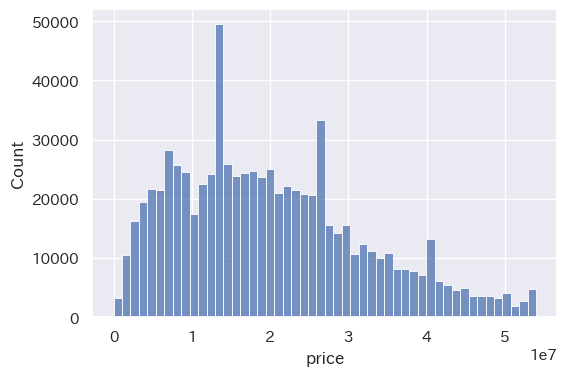

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(new_data["price"],kde=False,bins=50)
plt.show()
# プロットしてみる

`'取引時点'` 列に含まれるユニークな値を取得。

具体的には、`df['取引時点']` は `'取引時点'` 列のデータを取り出し、  
`.unique()` を使用してその列内のユニークな値を取得。  

##各都道府県にどのくらいのデータがあるか

In [ ]:
new_data.groupby('都道府県名').size()

都道府県名
三重県       2082
京都府      18379
佐賀県        737
兵庫県      48177
北海道      26773
千葉県      40774
和歌山県       984
埼玉県      47809
大分県       3281
大阪府      90700
奈良県       5985
宮城県      12201
宮崎県       1381
富山県       1128
山口県       2329
山形県        652
山梨県        668
岐阜県       1653
岡山県       3123
岩手県       1624
島根県        393
広島県       6576
徳島県        755
愛媛県       2410
愛知県      38224
新潟県       4306
東京都     213182
栃木県       2332
沖縄県       2268
滋賀県       4128
熊本県       3044
石川県       2027
神奈川県    109374
福井県        609
福岡県      37679
福島県       2267
秋田県        918
群馬県       2034
茨城県       4103
長崎県       2145
長野県       1476
青森県        869
静岡県       8048
香川県       2264
高知県        481
鳥取県        673
鹿児島県      2320
dtype: int64

#2.各Columnsの内容確認

###a.最寄駅：距離（分）

In [ ]:
new_data['最寄駅：距離（分）'].unique()

array([nan, '4', '13', '6', '14', '12', '11', '9', '2', '10', '5', '1',
       '8', '18', '3', '15', '16', '7', '30分?60分', '17', '19', '23', '29',
       '24', '20', '26', '21', '25', '22', '1H?1H30', '28', '0', '2H?',
       '27', '1H30?2H'], dtype=object)

In [ ]:
moyori_dict = {
    "30分?60分":45,
    "1H?1H30":75,
    "1H30?2H":105,
    "2H?":120
}
new_data["最寄駅：距離（分）"] = new_data["最寄駅：距離（分）"].replace(moyori_dict).astype(float)

<ipython-input-156-e3f4db56104f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["最寄駅：距離（分）"] = new_data["最寄駅：距離（分）"].replace(moyori_dict).astype(float)


In [ ]:
new_data['最寄駅：距離（分）'].unique()

array([ nan,   4.,  13.,   6.,  14.,  12.,  11.,   9.,   2.,  10.,   5.,
         1.,   8.,  18.,   3.,  15.,  16.,   7.,  45.,  17.,  19.,  23.,
        29.,  24.,  20.,  26.,  21.,  25.,  22.,  75.,  28.,   0., 120.,
        27., 105.])

###b.建築年

In [ ]:
new_data['建築年'].unique()

array(['昭和63年', '昭和62年', '平成17年', '平成6年', '平成8年', '昭和49年', '昭和53年',
       '昭和61年', '平成14年', '平成7年', '平成11年', '昭和55年', '平成4年', '平成10年',
       '昭和60年', '平成2年', nan, '昭和64年', '昭和58年', '昭和46年', '平成12年', '平成9年',
       '昭和50年', '昭和45年', '平成5年', '昭和57年', '平成16年', '昭和59年', '平成15年',
       '平成13年', '平成3年', '昭和54年', '昭和52年', '昭和56年', '昭和47年', '昭和43年',
       '昭和48年', '昭和41年', '昭和42年', '昭和51年', '戦前', '昭和44年', '昭和40年',
       '昭和33年', '昭和36年', '昭和30年', '平成18年', '昭和39年', '昭和38年', '昭和34年',
       '昭和35年', '昭和25年', '昭和28年', '昭和32年', '平成19年', '昭和31年', '平成20年',
       '昭和29年', '昭和27年', '平成22年', '平成21年', '昭和37年', '昭和24年', '平成23年',
       '昭和21年', '昭和22年', '平成24年', '平成25年', '昭和23年', '昭和26年', '平成26年',
       '平成27年', '平成28年', '平成29年', '平成30年', '平成31年', '令和2年', '令和3年',
       '令和4年', '令和5年'], dtype=object)

In [ ]:
y_list = {}
for i in new_data["建築年"].value_counts().keys():
    if "令和" in i:
        num = float(i.split("令和")[1].split("年")[0])
        year = 2018 + num
    elif "平成" in i:
        num = float(i.split("平成")[1].split("年")[0])
        year = 1988 + num
    elif "昭和" in i:
        num = float(i.split("昭和")[1].split("年")[0])
        year = 1925 + num
    y_list[i] = year
print(y_list)
new_data["建築年"] = new_data["建築年"].replace(y_list)

{'平成3年': 1991.0, '平成20年': 2008.0, '平成19年': 2007.0, '平成18年': 2006.0, '平成7年': 1995.0, '平成10年': 1998.0, '平成2年': 1990.0, '平成12年': 2000.0, '平成8年': 1996.0, '平成15年': 2003.0, '平成17年': 2005.0, '平成9年': 1997.0, '平成14年': 2002.0, '平成11年': 1999.0, '平成13年': 2001.0, '平成16年': 2004.0, '昭和64年': 1989.0, '平成4年': 1992.0, '昭和63年': 1988.0, '平成21年': 2009.0, '平成6年': 1994.0, '昭和62年': 1987.0, '昭和59年': 1984.0, '昭和60年': 1985.0, '昭和61年': 1986.0, '昭和49年': 1974.0, '平成5年': 1993.0, '平成22年': 2010.0, '昭和54年': 1979.0, '昭和57年': 1982.0, '昭和55年': 1980.0, '平成24年': 2012.0, '昭和56年': 1981.0, '平成23年': 2011.0, '平成25年': 2013.0, '昭和48年': 1973.0, '昭和58年': 1983.0, '昭和53年': 1978.0, '昭和50年': 1975.0, '平成26年': 2014.0, '昭和52年': 1977.0, '昭和51年': 1976.0, '平成27年': 2015.0, '昭和47年': 1972.0, '昭和46年': 1971.0, '平成28年': 2016.0, '昭和45年': 1970.0, '平成29年': 2017.0, '昭和44年': 1969.0, '昭和43年': 1968.0, '平成30年': 2018.0, '平成31年': 2019.0, '令和2年': 2020.0, '令和3年': 2021.0, '昭和42年': 1967.0, '昭和41年': 1966.0, '戦前': 1966.0, '令和4年': 2022.0, '昭和40年': 1965.0, '昭和39年': 1

<ipython-input-159-022722dba5fa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["建築年"] = new_data["建築年"].replace(y_list)


In [ ]:
new_data['建築年'].unique()

array([1988., 1987., 2005., 1994., 1996., 1974., 1978., 1986., 2002.,
       1995., 1999., 1980., 1992., 1998., 1985., 1990.,   nan, 1989.,
       1983., 1971., 2000., 1997., 1975., 1970., 1993., 1982., 2004.,
       1984., 2003., 2001., 1991., 1979., 1977., 1981., 1972., 1968.,
       1973., 1966., 1967., 1976., 1969., 1965., 1958., 1961., 1955.,
       2006., 1964., 1963., 1959., 1960., 1950., 1953., 1957., 2007.,
       1956., 2008., 1954., 1952., 2010., 2009., 1962., 1949., 2011.,
       1946., 1947., 2012., 2013., 1948., 1951., 2014., 2015., 2016.,
       2017., 2018., 2019., 2020., 2021., 2022., 2023.])

###c.建物の構造

In [ ]:
new_data['建物の構造'].unique()

array(['ＳＲＣ', 'ＲＣ', nan, 'ＳＲＣ、ＲＣ', '鉄骨造', 'ＲＣ、鉄骨造', '木造', 'ＳＲＣ、鉄骨造',
       'ブロック造', '軽量鉄骨造', 'ＲＣ、ブロック造', 'ＳＲＣ、ＲＣ、鉄骨造'], dtype=object)

###d.面積（㎡）

In [ ]:
new_data['面積（㎡）'].unique()

array([90, 25, 15, 45, 60, 75, 30, 55, 70, 20, 50, 80, 65, '15', '65', 40,
       '40', 85, '90', 95, '55', '25', 100, 35, '70', 110, '60', '30',
       '35', 105, '45', '20', '50', 10, '80', '10', 165, '75', '85', 120,
       '100', 190, '230', '185', 140, 155, '410', '95', 115, 180, 125,
       '350', '130', '115', 340, '630', 130, 145, '120', '780', '620',
       '105', '220', '135', '125', 1000, '190', 150, '320', '175', '140',
       220, '180', '250', 160, 135, '150', '210', '145', '110', 480,
       '200', 200, 250, '155', 210, 170, '360', '160', 185, 175, '260',
       '195', 230, 310, 290, 410, 260, 280, 380, 240, '165', '170', 195,
       450, '480', '470', 370, 270, 470, 580, 590, 300, 390, '300', '340',
       330, 680, '490', '450', 360, '660', '590', 900, 660, '390', 400,
       '290', 740, 770, 610, '650', 700, 780, 500, 760, 350, '710', '460',
       460, '970', 970, 790, '530', '400', '330', 600, 420, 1400, 490,
       710, 570, 990, 690, 550, 670, '2000㎡以上', 440, 880,

In [ ]:
new_data["面積（㎡）"] = new_data["面積（㎡）"].replace("2000㎡以上", 2000).astype(float)

<ipython-input-163-cf8bfea8eb7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["面積（㎡）"] = new_data["面積（㎡）"].replace("2000㎡以上", 2000).astype(float)


In [ ]:
new_data['面積（㎡）'].unique()

array([  90.,   25.,   15.,   45.,   60.,   75.,   30.,   55.,   70.,
         20.,   50.,   80.,   65.,   40.,   85.,   95.,  100.,   35.,
        110.,  105.,   10.,  165.,  120.,  190.,  230.,  185.,  140.,
        155.,  410.,  115.,  180.,  125.,  350.,  130.,  340.,  630.,
        145.,  780.,  620.,  220.,  135., 1000.,  150.,  320.,  175.,
        250.,  160.,  210.,  480.,  200.,  170.,  360.,  260.,  195.,
        310.,  290.,  280.,  380.,  240.,  450.,  470.,  370.,  270.,
        580.,  590.,  300.,  390.,  330.,  680.,  490.,  660.,  900.,
        400.,  740.,  770.,  610.,  650.,  700.,  500.,  760.,  710.,
        460.,  970.,  790.,  530.,  600.,  420., 1400.,  570.,  990.,
        690.,  550.,  670., 2000.,  440.,  880.,  560.])

#3.欠損値の数とデータの型

####全体像の確認　欠損値の数確認

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765345 entries, 0 to 806995
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            765345 non-null  int64  
 1   都道府県名         765345 non-null  object 
 2   市区町村名         765345 non-null  object 
 3   地区名           764682 non-null  object 
 4   最寄駅：名称        762540 non-null  object 
 5   最寄駅：距離（分）     742977 non-null  float64
 6   間取り           735885 non-null  object 
 7   面積（㎡）         765345 non-null  float64
 8   建築年           742572 non-null  float64
 9   建物の構造         742526 non-null  object 
 10  用途            678934 non-null  object 
 11  今後の利用目的       408673 non-null  object 
 12  都市計画          744854 non-null  object 
 13  建ぺい率（％）       740219 non-null  float64
 14  容積率（％）        740219 non-null  float64
 15  取引時点          765345 non-null  object 
 16  改装            687947 non-null  object 
 17  取引の事情等        19409 non-null   object 
 18  取引価格（総額）_

####欠損値の内容確認

In [ ]:
new_data[new_data.isnull().any(axis=1)]

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,price
0,27278791,大阪府,大阪市城東区,放出西,鴫野,NaN,４ＬＤＫ,90.0,1988.0,ＳＲＣ,住宅,NaN,準工業地域,60.0,200.0,2005年第3四半期,改装済,NaN,7.414973,26000000.0
1,27287304,大阪府,大阪市中央区,内久宝寺町,谷町四丁目,4.0,１Ｋ,25.0,1987.0,ＳＲＣ,店舗,NaN,商業地域,80.0,800.0,2005年第3四半期,未改装,NaN,6.845098,7000000.0
2,13378024,東京都,杉並区,下井草,鷺ノ宮,13.0,１Ｋ,15.0,2005.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,300.0,2005年第3四半期,未改装,NaN,7.322219,21000000.0
3,13260464,東京都,大田区,鵜の木,鵜の木,6.0,NaN,45.0,1994.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,未改装,NaN,7.322219,21000000.0
5,14251810,神奈川県,横浜市港北区,菊名,菊名,NaN,３ＬＤＫ,60.0,1996.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,未改装,NaN,7.447158,28000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806991,4000462,宮城県,仙台市青葉区,一番町,青葉通一番町,14.0,２ＬＤＫ,55.0,1992.0,ＳＲＣ,住宅,住宅,商業地域,80.0,500.0,2022年第4四半期,改装済,NaN,7.397940,25000000.0
806992,4009949,宮城県,仙台市太白区,郡山,太子堂,16.0,３ＬＤＫ,65.0,1995.0,ＲＣ,NaN,住宅,第２種住居地域,60.0,200.0,2022年第4四半期,NaN,NaN,7.255273,18000000.0
806993,13012344,東京都,新宿区,喜久井町,早稲田(メトロ),2.0,１Ｋ,20.0,1985.0,ＲＣ,NaN,住宅,第１種中高層住居専用地域,60.0,300.0,2022年第4四半期,改装済,NaN,7.041393,11000000.0
806994,4004394,宮城県,仙台市青葉区,広瀬町,北四番丁,16.0,３ＬＤＫ,80.0,2002.0,ＲＣ、鉄骨造,住宅,住宅,近隣商業地域,80.0,300.0,2022年第4四半期,未改装,NaN,7.361728,23000000.0


In [ ]:
new_data2 = new_data.dropna(subset=['最寄駅：距離（分）',"面積（㎡）","建築年","建ぺい率（％）","容積率（％）"])

In [ ]:
new_data2['最寄駅：距離（分）'].isnull().sum()

0

In [ ]:
new_data2.isnull().sum()

ID                   0
都道府県名                0
市区町村名                0
地区名                573
最寄駅：名称               0
最寄駅：距離（分）            0
間取り              25439
面積（㎡）                0
建築年                  0
建物の構造            12756
用途               77912
今後の利用目的         320883
都市計画               106
建ぺい率（％）              0
容積率（％）               0
取引時点                 0
改装               68686
取引の事情等          691420
取引価格（総額）_log         0
price                0
dtype: int64

In [ ]:
new_data2.shape
# データ数確認

(708944, 20)

In [ ]:
new_data3 = new_data2.drop(["取引の事情等","最寄駅：名称","地区名","price"], axis=1)
# 取引の事情等","最寄駅：名称","地区名をドロップ
new_data3.head()

,ID,都道府県名,市区町村名,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引価格（総額）_log
1,27287304,大阪府,大阪市中央区,4.0,１Ｋ,25.0,1987.0,ＳＲＣ,店舗,NaN,商業地域,80.0,800.0,2005年第3四半期,未改装,6.845098
2,13378024,東京都,杉並区,13.0,１Ｋ,15.0,2005.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,300.0,2005年第3四半期,未改装,7.322219
3,13260464,東京都,大田区,6.0,NaN,45.0,1994.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,未改装,7.322219
6,13445788,東京都,練馬区,14.0,４ＬＤＫ,75.0,1974.0,ＲＣ,住宅,NaN,第１種中高層住居専用地域,60.0,200.0,2005年第3四半期,未改装,7.176091
10,23239892,愛知県,名古屋市港区,12.0,NaN,55.0,1986.0,ＲＣ,店舗,NaN,近隣商業地域,80.0,200.0,2005年第3四半期,未改装,6.792392


####数字と文字列の確認

In [ ]:
quantitative = [f for f in new_data3.columns if new_data3.dtypes[f] != 'object']
quantitative.remove('ID')

print("数字")
print(quantitative)

qualitative = [f for f in new_data3.columns if new_data3.dtypes[f] == 'object']

print(" 文字列型 ")
print(qualitative)

数字
['最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log']
 文字列型 
['都道府県名', '市区町村名', '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '取引時点', '改装']


In [ ]:
sum_data = new_data3.groupby(["都道府県名","取引価格（総額）_log"]).sum()
sum_data1 = sum_data.sort_values(by='取引価格（総額）_log',ascending=False)
sum_data1

,,ID,市区町村名,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装
都道府県名,取引価格（総額）_log,,,,,,,,,,,,,,
鹿児島県,7.732394,46033509,鹿児島市,3.0,３ＬＤＫ,100.0,2010.0,ＳＲＣ,住宅,0,商業地域,80.0,500.0,2010年第3四半期,未改装
新潟県,7.732394,30076832,新潟市中央区新潟市中央区,17.0,４ＬＤＫ２ＬＤＫ,195.0,4016.0,ＲＣＲＣ,住宅住宅,住宅,商業地域第２種住居地域,140.0,800.0,2010年第3四半期2017年第1四半期,未改装未改装
宮城県,7.732394,48102713,仙台市青葉区仙台市青葉区仙台市青葉区仙台市青葉区仙台市青葉区仙台市青葉区仙台市青葉区仙台市青...,98.0,４ＬＤＫ３ＬＤＫ３ＬＤＫ１ＬＤＫ３ＬＤＫ４ＬＤＫ４ＬＤＫ３ＬＤＫ３ＬＤＫ１ＬＤＫ４ＬＤＫ３ＬＤＫ,1040.0,24145.0,ＲＣＲＣＲＣＲＣＲＣＲＣＲＣＲＣＲＣＲＣＲＣＲＣ,住宅住宅住宅住宅住宅住宅住宅住宅住宅住宅,住宅住宅住宅住宅住宅住宅住宅住宅住宅住宅住宅住宅,近隣商業地域商業地域商業地域商業地域商業地域近隣商業地域近隣商業地域商業地域商業地域第２種中...,940.0,5200.0,2015年第3四半期2016年第2四半期2016年第2四半期2016年第4四半期2017年第...,未改装未改装未改装改装済改装済未改装未改装未改装未改装改装済
香川県,7.732394,37013989,高松市,10.0,３ＬＤＫ,115.0,2008.0,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2017年第4四半期,未改装
茨城県,7.732394,8058630,つくば市,4.0,３ＬＤＫ,105.0,2009.0,ＲＣ,0,住宅,第１種低層住居専用地域,40.0,60.0,2017年第4四半期,未改装
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
新潟県,2.991226,15053072,新潟市中央区,21.0,２ＬＤＫ,50.0,1995.0,ＲＣ,住宅,0,第１種住居地域,60.0,200.0,2012年第3四半期,0
神奈川県,2.977724,14283569,厚木市,45.0,３ＬＤＫ,80.0,1995.0,ＲＣ,住宅,0,第１種住居地域,60.0,200.0,2010年第2四半期,未改装
福岡県,2.845098,40065209,北九州市八幡東区,23.0,３ＬＤＫ,65.0,1981.0,ＳＲＣ,住宅,0,商業地域,80.0,400.0,2014年第1四半期,未改装


In [ ]:
new_data3.groupby(["面積（㎡）","取引価格（総額）_log"]).mean()

TypeError: Could not convert 静岡県静岡県静岡県静岡県静岡県静岡県 to numeric

####crosstab

In [ ]:
print(pd.crosstab(new_data3["面積（㎡）"],new_data3["取引価格（総額）_log"]))

取引価格（総額）_log  2.653213  2.724276  2.845098  2.977724  2.991226  3.000000  \
面積（㎡）                                                                      
10.0                 0         0         0         0         0         6   
15.0                 0         0         0         0         0         0   
20.0                 0         0         0         0         0         0   
25.0                 0         0         0         0         0         0   
30.0                 0         0         0         0         0         0   
...                ...       ...       ...       ...       ...       ...   
970.0                0         0         0         0         0         0   
990.0                0         0         0         0         0         0   
1000.0               0         0         0         0         0         0   
1400.0               0         0         0         0         0         0   
2000.0               0         0         0         0         0         0   

取引価格（総額）_lo

In [ ]:
print(pd.crosstab(new_data3["建築年"],new_data2["取引価格（総額）_log"]))


取引価格（総額）_log  2.653213  2.724276  2.845098  2.977724  2.991226  3.000000  \
建築年                                                                        
1946.0               0         0         0         0         0         0   
1947.0               0         0         0         0         0         0   
1948.0               0         0         0         0         0         0   
1949.0               0         0         0         0         0         0   
1950.0               0         0         0         0         0         0   
...                ...       ...       ...       ...       ...       ...   
2019.0               0         0         0         0         0         0   
2020.0               0         0         0         0         0         0   
2021.0               0         0         0         0         0         0   
2022.0               0         0         0         0         0         0   
2023.0               0         0         0         0         0         0   

取引価格（総額）_lo

###各列統計量の可視化

##作図

###ヒストグラム

100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


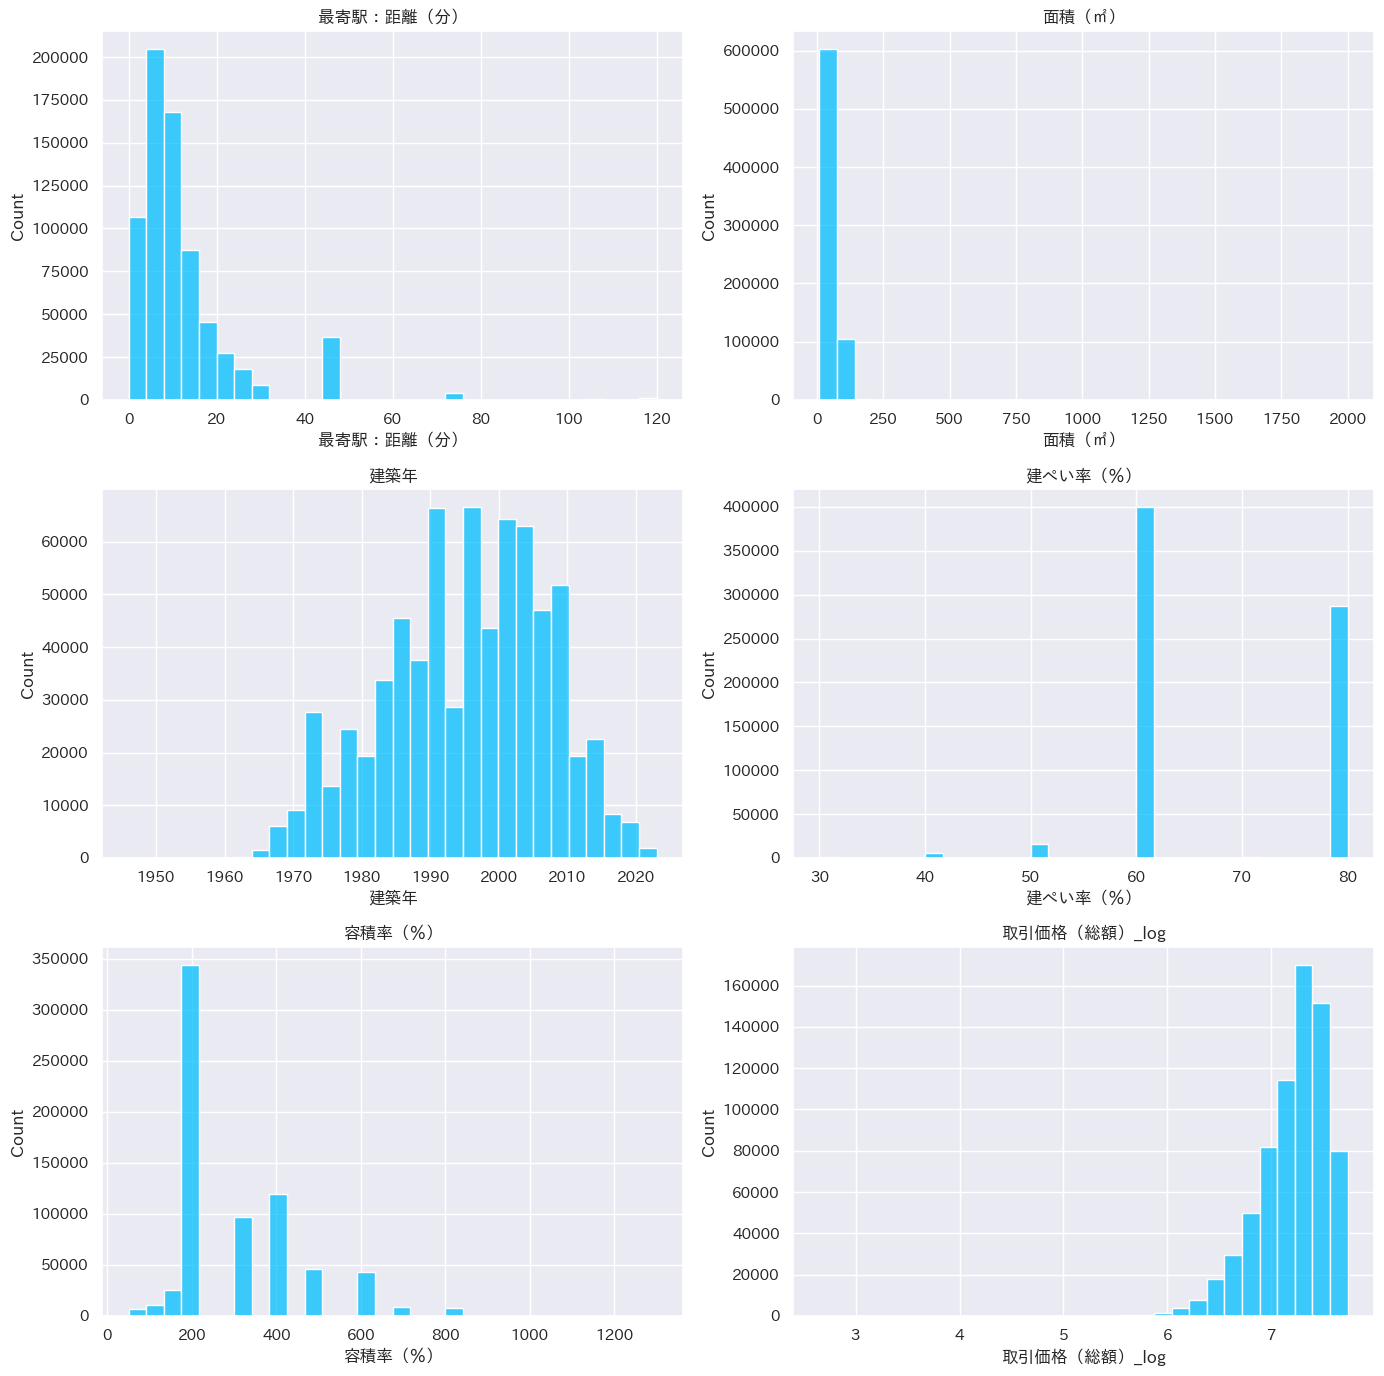

In [ ]:
from tqdm import tqdm
plt.figure(figsize=(14,18))

for i,col in enumerate(tqdm(quantitative)):
    plt.subplot(int(len(qualitative)/2), 2, i+1)
    g = sns.histplot(new_data3[col], kde=False, bins=30, color='deepskyblue')
    g.set_title( col )

plt.tight_layout()
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]<ipython-input-178-69a374378b5e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8)
 11%|█         | 1/9 [00:01<00:10,  1.28s/it]<ipython-input-178-69a374378b5e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8)
 22%|██▏       | 2/9 [00:03<00:12,  1.73s/it]<ipython-input-178-69a374378b5e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8)
 33%|███▎      | 3/9 [00:05<00:11,  1.87s/it]<ipython-input-178-69a374378b5e>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8)
 44%|████▍     | 4/9 [00:06<00:08,  1.64s/it]<ipython-input-178-69a374378b5e>:14: UserWarning: FixedFormatter should only be

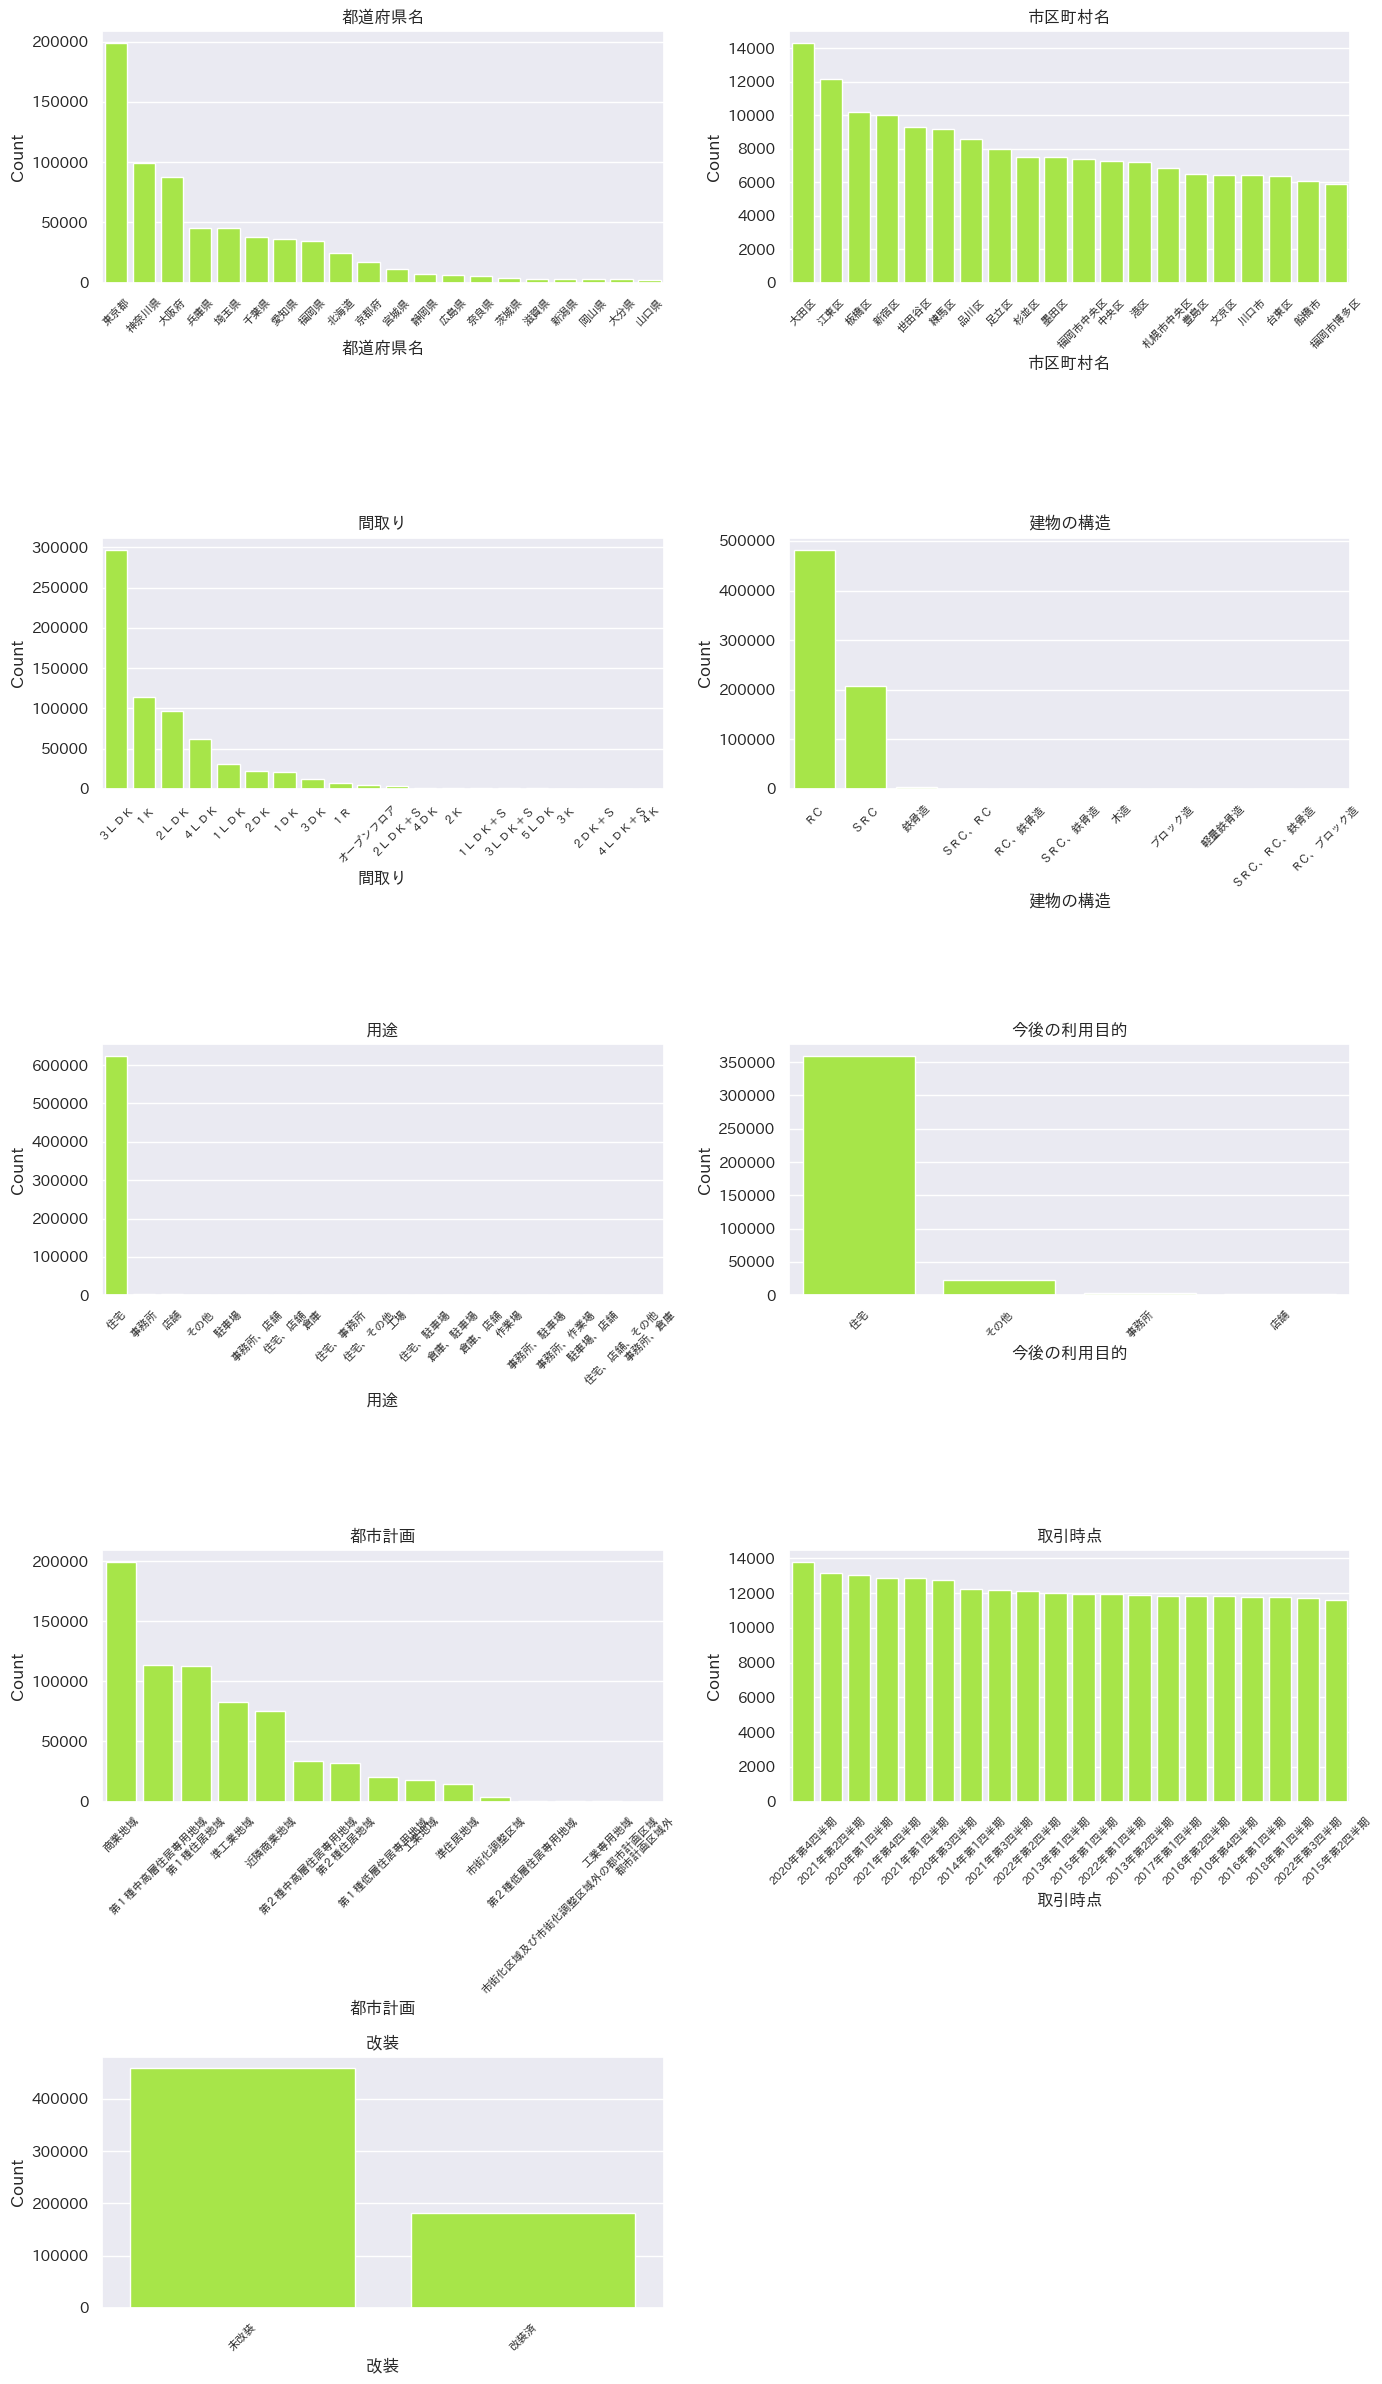

In [ ]:
plt.figure(figsize=(14,24))

for i,col in enumerate(tqdm(qualitative)):

    types = new_data3[col].value_counts()[:20]
    types.index = [x for x in types.index]

    plt.subplot(int(len(qualitative)/2)+1, 2, i+1)
    g = sns.countplot(x=col,
                        data=new_data3,
                        color='greenyellow', order =types.index.values)
    g.set_title( col )
    g.set_ylabel("Count")
    g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8)

plt.tight_layout()
plt.show()

###ヒートマップ

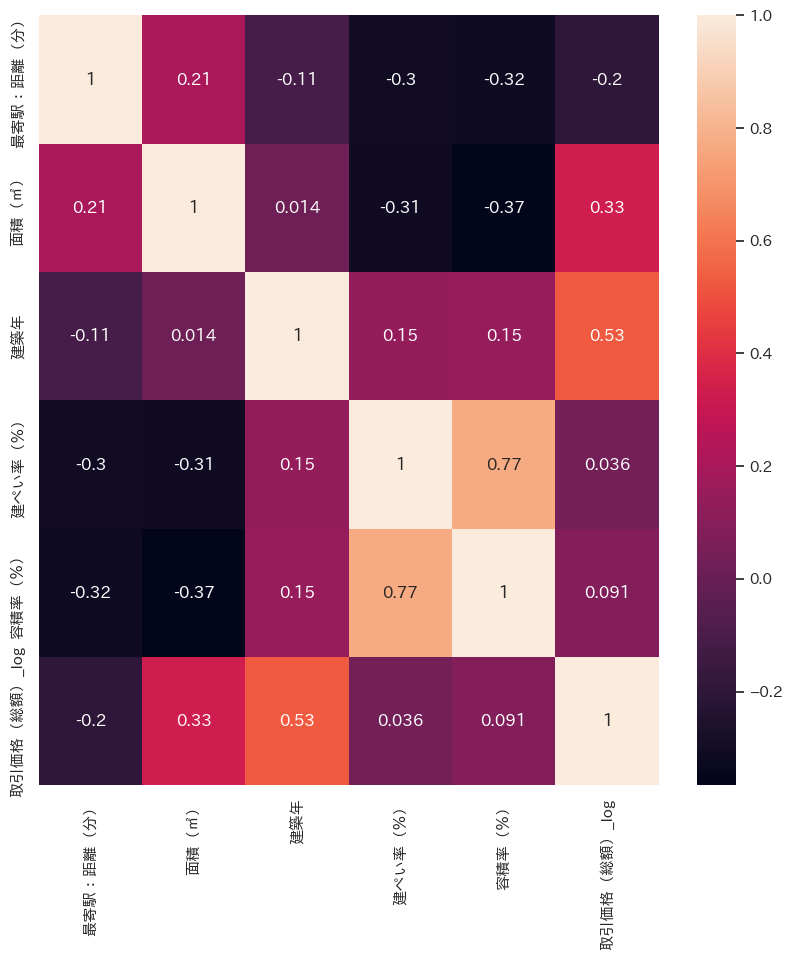

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(new_data3[quantitative].corr(), annot=True)
plt.show()

In [ ]:
new_data3.isnull().sum()

ID                   0
都道府県名                0
市区町村名                0
最寄駅：距離（分）            0
間取り              25439
面積（㎡）                0
建築年                  0
建物の構造            12756
用途               77912
今後の利用目的         320883
都市計画               106
建ぺい率（％）              0
容積率（％）               0
取引時点                 0
改装               68686
取引価格（総額）_log         0
dtype: int64

In [ ]:
new_data3.describe()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log
count,7.089440e+05,708944.000000,708944.000000,708944.000000,708944.000000,708944.000000,708944.000000
mean,1.866314e+07,11.719621,56.873194,1995.277080,67.731245,300.097370,7.207099
std,9.539053e+06,12.122951,23.875852,11.782286,10.400082,146.636925,0.329338
min,1.000009e+06,0.000000,10.000000,1946.000000,30.000000,50.000000,2.653213
25%,1.309049e+07,5.000000,40.000000,1987.000000,60.000000,200.000000,7.041393
50%,1.406509e+07,8.000000,60.000000,1996.000000,60.000000,200.000000,7.278754
75%,2.706543e+07,14.000000,70.000000,2005.000000,80.000000,400.000000,7.447158
max,4.703722e+07,120.000000,2000.000000,2023.000000,80.000000,1300.000000,7.732394


#4.面積・建設年

###散布図

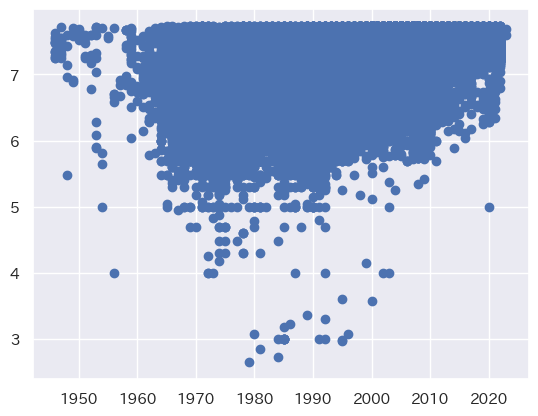

In [ ]:
# 散布図
plt.scatter(new_data3["建築年"], new_data3["取引価格（総額）_log"])

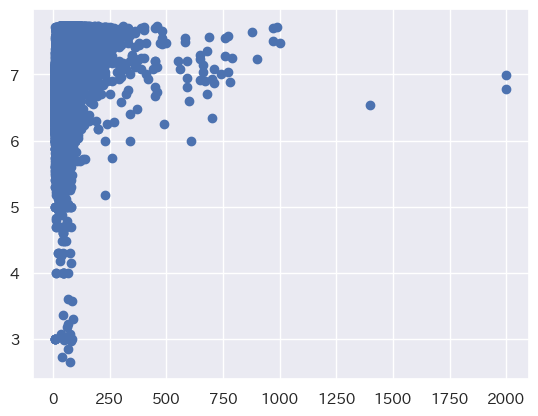

In [ ]:
# 散布図
plt.scatter(new_data3["面積（㎡）"], new_data3["取引価格（総額）_log"])

#原本

In [ ]:
new_data3['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期', '2006年第2四半期',
       '2006年第3四半期', '2006年第4四半期', '2007年第1四半期', '2007年第2四半期',
       '2007年第3四半期', '2007年第4四半期', '2008年第1四半期', '2008年第2四半期',
       '2008年第3四半期', '2008年第4四半期', '2009年第1四半期', '2009年第2四半期',
       '2009年第3四半期', '2009年第4四半期', '2010年第1四半期', '2010年第2四半期',
       '2010年第3四半期', '2010年第4四半期', '2011年第1四半期', '2011年第2四半期',
       '2011年第3四半期', '2011年第4四半期', '2012年第1四半期', '2012年第2四半期',
       '2012年第3四半期', '2012年第4四半期', '2013年第1四半期', '2013年第2四半期',
       '2013年第3四半期', '2013年第4四半期', '2014年第1四半期', '2014年第2四半期',
       '2014年第3四半期', '2014年第4四半期', '2015年第1四半期', '2015年第2四半期',
       '2015年第3四半期', '2015年第4四半期', '2016年第1四半期', '2016年第2四半期',
       '2016年第3四半期', '2016年第4四半期', '2017年第1四半期', '2017年第2四半期',
       '2017年第3四半期', '2017年第4四半期', '2018年第1四半期', '2018年第2四半期',
       '2018年第3四半期', '2018年第4四半期', '2019年第1四半期', '2019年第2四半期',
       '2019年第3四半期', '2019年第4四半期', '2020年第1四半期', '2020年第2四半期',
       '2020年第3四半期', '2020年第4四半期', '2021年第1四半期', '2021年

インデックスの中で最小の値（最も古い日付）を見つけます。

1. `val_min_idx` は、`df['取引時点']` 列が `'2022年第3四半期'` または `'2022年第4四半期'` の中で最小の値を取得。
2. `test_min_idx` は、`df['取引時点']` 列が `'2023年第1四半期'` または `'2023年第2四半期'` 中で最小の値を取得。

訓練データとテストデータの期間内で、それぞれ2番目および1番目に新しい四半期の最初の値を取得

In [ ]:
# 訓練データの期間のうち2番目、1番目に新しい四半期を指定する
val_min_idx = min(df[df['取引時点'].str.contains('2022年第3四半期|2022年第4四半期', regex=True)].index)
# テストの期間の四半期を2つ指定する
test_min_idx = min(df[df['取引時点'].str.contains('2023年第1四半期|2023年第2四半期', regex=True)].index)
val_min_idx, test_min_idx

(780128, 806996)

`val_min_idx` から `test_min_idx` の `'取引時点'` 列に含まれるユニークな値のセット。

`df.iloc[val_min_idx:test_min_idx, :]` は、`val_min_idx` から `test_min_idx` までの行と全ての列を含むデータフレームを取得します。  
`.values` を使ってこの部分データフレームの値を配列として取得。

`set()` ユニークな値を取得し  
重複を排除したセットを生成します。

In [ ]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2022年第3四半期', '2022年第4四半期'}

1. `set(df['取引時点'].values)` を使って、`'取引時点'` 列に含まれるユニークな値のセットを作成。
2. `list()` を使ってセットをリストに変換し、`sorted()` を使って昇順にソート。

 これにより、ユニークな値が昇順で並ぶリストが得られます。
3. `enumerate()` を使って、ソートされた値のリストを反復処理。  
これにより、各値に対してインデックス番号を付与。
4. `enc_dic` 辞書に、元の値をキーとし、エンコードされた整数を値として追加。
5. `map()` を使って、元の `'取引時点'` 列を `enc_dic` に基づいて整数にマッピング。  
新しい列 `'取引時点_enc'` にこの整数エンコーディングを格納。

元の `'取引時点'` 列の各値が整数値に変換。

In [ ]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

time encoding手法を使用  
タイムエンコーディングは、過去の時点までの時間の経過に基づいて特徴量をエンコードする方法。

各タイムステップ（エンコーディングされた時点）において、都道府県ごとの `'取引価格（総額）_log'` 列の平均を計算し、  
その結果を `te_dic` に格納。   
過去の時点までの平均価格が都道府県ごとに得られます。

`te_dic[50]` は、50番目のタイムステップにおける都道府県ごとの平均価格。

In [ ]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836439,
 '京都府': 7.155935848555253,
 '佐賀県': 7.009937258263509,
 '兵庫県': 7.157742870483196,
 '北海道': 6.965967793677859,
 '千葉県': 7.155825324964995,
 '和歌山県': 7.022690210815773,
 '埼玉県': 7.1697442713966355,
 '大分県': 6.911537826573079,
 '大阪府': 7.158352973821201,
 '奈良県': 7.056884610234688,
 '宮城県': 7.0395442538048805,
 '宮崎県': 6.958678653711235,
 '富山県': 7.0469200713870155,
 '山口県': 7.045342730349803,
 '山形県': 7.087990602814902,
 '山梨県': 6.848839888686708,
 '岐阜県': 7.078095913486453,
 '岡山県': 7.03809073492747,
 '岩手県': 6.925002679060599,
 '島根県': 7.165376214700312,
 '広島県': 7.093449021655064,
 '徳島県': 6.912051981629745,
 '愛媛県': 6.966433011596662,
 '愛知県': 7.107301969238601,
 '新潟県': 6.913835156235044,
 '東京都': 7.377929204641064,
 '栃木県': 6.950636958071011,
 '沖縄県': 7.160046604428336,
 '滋賀県': 7.16602695816839,
 '熊本県': 6.970182251843263,
 '石川県': 6.929363348877185,
 '神奈川県': 7.2581182672098175,
 '福井県': 6.979575815840195,
 '福岡県': 6.992264905042226,
 '福島県': 6.9743805791401785,
 '秋田県': 6.9413137471126

各行に対してタイムエンコーディングの計算を行い、  
新しい列 `group_col+'_te'` にその結果を追加。

`calc_te()` 関数は、各行に対して呼び出され、その行の `'取引時点_enc'` と `'都道府県名'` に基づいてタイムエンコーディングを計算。  
`te_dic`からタイムステップと都道府県名に対応する平均価格を取得し。  
もし対応する情報が見つからない場合は0。

`df.apply(calc_te, axis=1)` は、各行に `calc_te()` 関数を適用し、その結果を新しい列に追加。最終的に、新しい列 `group_col+'_te'` がデータフレーム `df` に追加

In [ ]:
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,...,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,price,取引時点_enc,都道府県名_te
0,27278791,大阪府,大阪市城東区,放出西,鴫野,NaN,４ＬＤＫ,90,昭和63年,ＳＲＣ,...,準工業地域,60.0,200.0,2005年第3四半期,改装済,NaN,7.414973,26000000.0,0,0.0
1,27287304,大阪府,大阪市中央区,内久宝寺町,谷町四丁目,4,１Ｋ,25,昭和62年,ＳＲＣ,...,商業地域,80.0,800.0,2005年第3四半期,未改装,NaN,6.845098,7000000.0,0,0.0


`'取引時点'` 列の情報から新しい特徴量を作成し、`'取引時点'` 列を削除。

1. `'取引時点_何年前'` 列の追加：`'取引時点'` 列から年を抽出、2021年からその値を減算、「何年前の取引か」という特徴量を表す新しい列を追加。
2. `'取引時点'` 列の削除：元の `'取引時点'` をデータフレームから削除。
3. `'建築年'` 列の変換：`'建築年'` 列の和暦を西暦に変換。`convert_wareki_to_seireki` 関数。
4. `'面積（㎡）'` 正規化：`'面積（㎡）'` 値を正規化。 `normalize_area` 関数。
5. `'最寄駅：距離（分）'` 正規化：`'最寄駅：距離（分）'` を正規化。 `normalize_moyori` 関数


In [ ]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

1. `select_categorical(df)`: DataFrameからobject型またはcategory型を選択。

2. `select_numerical(df)`: DataFrameから数値（int型またはfloat型）のみを選択。

3. `encode_labels(df)`: カテゴリカルな列をLabelEncoderを用いてエンコード。  
NaN値が存在する場合、 "Missing"。

4. `combinate_yoseki(df)`: DataFrame内'面積（㎡）'と'容積率（％）'を掛け合わせて新しい列を作成

In [ ]:
def select_categorical(df: pd.DataFrame):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    return df[categorical_columns].copy()

def select_numerical(df: pd.DataFrame):
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    return df[numerical_columns].copy()

def encode_labels(df: pd.DataFrame):
    df.fillna("Missing", inplace = True)
    for col in df.columns:
        encoded = LabelEncoder().fit_transform(df[col].copy())
        df[col] = encoded
    return df

def combinate_yoseki(df: pd.DataFrame):
    df["面積（㎡）容積率（％）_combi"] = df["面積（㎡）"] * df["容積率（％）"]
    return df[["面積（㎡）容積率（％）_combi"]].copy()



1. FunctionTransformerはscikit-learnの機能  
Transformerとしてラップするために使用。  
2. select_numerical関数をFunctionTransformerに適用、DataFrameから数値列のみを選択

3. head(2)メソッドを使用して変換されたDataFrameの最初の2行を表示。

In [ ]:
num_df = FunctionTransformer(select_numerical).fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,price,取引時点_enc,都道府県名_te,取引時点_何年前
0,27278791,NaN,90,1988.0,60.0,200.0,7.414973,26000000.0,0,0.0,16
1,27287304,4.0,25,1987.0,80.0,800.0,6.845098,7000000.0,0,0.0,16



1. make_pipelineは、複数の変換ステップを連結してパイプラインを作成するためのユーティリティ関数。  
2. カテゴリカル列の選択とラベルのエンコーディングの2つのステップを含むパイプラインを作成。

In [ ]:
encoder = make_pipeline(
    FunctionTransformer(select_categorical),
    FunctionTransformer(encode_labels),
)

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,9,204,5989,3837,51,10,7,0,7,1,0
1,9,200,1910,3416,7,10,20,0,1,2,0


数値列を選択し、それらの列を組み合わせた新しい列を作成。  
数値列の選択と組み合わせの操作

1. `encoder = make_pipeline(...)`: `make_pipeline`:複数のステップを組み合わせ、数値列の選択と組み合わせ操作。

2. `FunctionTransformer(select_numerical)`: 数値列を選択する。変換は`select_numerical`

3. `FunctionTransformer(combinate_yoseki)`: 数値列を組み合わせる変換は`combinate_yoseki`

4. `encoder.fit_transform(df)`: 作成を元のデータフレームに適用し、数値列の選択と組み合わせ操作を実行。

5. `/100`: 新しい列を100で除算します。

6. `num_comb_df.head(2)`: 最初の2行を表示。

元のデータフレームから数値列を選択し、それらの列を組み合わせた新しい列を作成し、その結果を100で除算すること。

In [ ]:
encoder = make_pipeline(
    FunctionTransformer(select_numerical),
    FunctionTransformer(combinate_yoseki),
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,180.0
1,200.0


グループ化し、指定された列ごとに複数の統計量（count、mean、min、max）を計算。

1. `get_agg_df(df, group_col)`: グループ化し、指定された列ごとに統計量を計算。"最寄駅：距離（分）"、"面積（㎡）"、"建ぺい率（％）"、"容積率（％）"の4つの列

2. `agg_cols`: 計算する対象の列のリストを定義。

3. `cols`: group_colとagg_colsを組み合わせた列のリストを定義。

4. `functions`: 計算するための関数のリストを定義（count、mean、min、max）。

5. `for col, function in product(agg_cols, functions)`: agg_colsとfunctionsの各要素の組み合わせに対して、列名と統計関数を組み合わせた列名を生成。

6. `agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function)`: 各統計関数に対して、グループごとに計算し、結果を新しい列としてagg_dfに追加。

7. `return agg_df.drop(cols, axis=1)`: 不要な元の列を削除、計算されたもののみを含むDataFrameへ。

`group_col`が"市区町村名"である場合、各市区町村ごとに"最寄駅：距離（分）"、"面積（㎡）"、"建ぺい率（％）"、"容積率（％）"を計算し、それぞれの結果を新しいDataFrameへ。

In [ ]:
agg_dfs = []

def get_agg_df(df, group_col):
    # agg_df = df.groupby(group_col).agg({
    #     "最寄駅：距離（分）": ["count", "mean", "min", "max"],
    #     "面積（㎡）": ["count", "mean", "min", "max"],
    #     "建ぺい率（％）": ["count", "mean", "min", "max"],
    #     "容積率（％）": ["count", "mean", "min", "max"]
    # }).reset_index()
    agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
    cols = [group_col] + agg_cols
    agg_df = df[cols].copy()
    functions = ["count", "mean", "min", "max"]
    for col, function in product(agg_cols, functions):
        col_name = f"{col}_{function}"
        agg_df[col_name] = agg_df.groupby(group_col)[col].transform(function)
    return agg_df.drop(cols, axis = 1)

group_col = '市区町村名'
agg_df = get_agg_df(df, group_col)
agg_df.head(2)

,最寄駅：距離（分）_count,最寄駅：距離（分）_mean,最寄駅：距離（分）_min,最寄駅：距離（分）_max,面積（㎡）_count,面積（㎡）_mean,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,2656,5.978539,0.0,19.0,2712,62.236357,10,760,2680,71.421642,50.0,80.0,2680,270.149254,200.0,600.0
1,6492,4.109673,0.0,16.0,6628,43.343392,10,690,6586,79.896751,60.0,80.0,6586,653.112663,100.0,1200.0


In [ ]:
agg_df.shape

(826117, 16)

いくつかのDataFrameを連結して新しいDataFrameを作成

1. `pd.concat([num_df, le_df, num_comb_df, agg_df], axis=1)`: `pd.concat`使用して、与えられたDataFrameを横方向（axis=1）に連結。
   - `num_df`: 数値列のみ
   - `le_df`: カテゴリカル列をラベルエンコーディング
   - `num_comb_df`: 数値列を組み合わせた新しい列
   - `agg_df`: グループごとに計算された

2. `print(feat_df.shape)`: 作成された `feat_df` の形状（行数と列数）を表示。

このコードの目的は、異なる特徴量を持つ複数のDataFrameを連結して、それらを1つの大きなDataFrameに統合し、機械学習モデルの入力として使用すること。

In [ ]:
feat_df = pd.concat([num_df,le_df,num_comb_df, agg_df], axis=1)
print(feat_df.shape)

In [ ]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,price,取引時点_enc,都道府県名_te,...,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,27278791,NaN,90,1988.0,60.0,200.0,7.414973,26000000.0,0,0.0,...,10,760,2680,71.421642,50.0,80.0,2680,270.149254,200.0,600.0
1,27287304,4.0,25,1987.0,80.0,800.0,6.845098,7000000.0,0,0.0,...,10,690,6586,79.896751,60.0,80.0,6586,653.112663,100.0,1200.0
2,13378024,13.0,15,2005.0,60.0,300.0,7.322219,21000000.0,0,0.0,...,10,470,9119,68.950543,30.0,80.0,9119,283.524509,60.0,600.0
3,13260464,6.0,45,1994.0,60.0,200.0,7.322219,21000000.0,0,0.0,...,10,340,16304,67.073724,40.0,80.0,16304,295.132483,80.0,800.0
4,13104441,NaN,65,2003.0,80.0,500.0,7.763428,58000000.0,0,0.0,...,10,1500,3939,77.735466,60.0,80.0,3939,571.972582,300.0,900.0


In [ ]:
pd.set_option('display.max_columns', 100)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,price,取引時点_enc,都道府県名_te,取引時点_何年前,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等,面積（㎡）容積率（％）_combi,最寄駅：距離（分）_count,最寄駅：距離（分）_mean,最寄駅：距離（分）_min,最寄駅：距離（分）_max,面積（㎡）_count,面積（㎡）_mean,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,27278791,NaN,90,1988.0,60.0,200.0,7.414973,26000000.0,0,0.0,16,9,204,5989,3837,51,10,7,0,7,1,0,180.0,2656,5.978539,0.0,19.0,2712,62.236357,10,760,2680,71.421642,50.0,80.0,2680,270.149254,200.0,600.0
1,27287304,4.0,25,1987.0,80.0,800.0,6.845098,7000000.0,0,0.0,16,9,200,1910,3416,7,10,20,0,1,2,0,200.0,6492,4.109673,0.0,16.0,6628,43.343392,10,690,6586,79.896751,60.0,80.0,6586,653.112663,100.0,1200.0
2,13378024,13.0,15,2005.0,60.0,300.0,7.322219,21000000.0,0,0.0,16,26,355,651,3870,7,5,7,0,11,2,0,45.0,8929,7.134842,0.0,120.0,9170,40.803162,10,470,9119,68.950543,30.0,80.0,9119,283.524509,60.0,600.0
3,13260464,6.0,45,1994.0,60.0,200.0,7.322219,21000000.0,0,0.0,16,26,198,12109,3840,0,5,7,0,11,2,0,90.0,15933,7.078014,0.0,75.0,16487,41.065082,10,340,16304,67.073724,40.0,80.0,16304,295.132483,80.0,800.0
4,13104441,NaN,65,2003.0,80.0,500.0,7.763428,58000000.0,0,0.0,16,26,117,11726,2452,28,10,7,0,1,2,0,325.0,3822,3.372841,0.0,12.0,4013,40.773735,10,1500,3939,77.735466,60.0,80.0,3939,571.972582,300.0,900.0


feat_df内の各列について欠損値の数をカウント

In [ ]:
feat_df.isnull().sum()

ID                       0
最寄駅：距離（分）            23271
面積（㎡）                    0
建築年                  24193
建ぺい率（％）              26300
容積率（％）               26300
取引価格（総額）_log         19121
price                19121
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    26300
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         264
最寄駅：距離（分）_min          264
最寄駅：距離（分）_max          264
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容

##Columns内容確認

In [ ]:
feat_df.dtypes

ID                     int64
最寄駅：距離（分）            float64
面積（㎡）                  int64
建築年                  float64
建ぺい率（％）              float64
容積率（％）               float64
取引価格（総額）_log         float64
price                float64
取引時点_enc               int64
都道府県名_te             float64
取引時点_何年前               int64
都道府県名                  int64
市区町村名                  int64
地区名                    int64
最寄駅：名称                 int64
間取り                    int64
建物の構造                  int64
用途                     int64
今後の利用目的                int64
都市計画                   int64
改装                     int64
取引の事情等                 int64
面積（㎡）容積率（％）_combi    float64
最寄駅：距離（分）_count        int64
最寄駅：距離（分）_mean       float64
最寄駅：距離（分）_min        float64
最寄駅：距離（分）_max        float64
面積（㎡）_count            int64
面積（㎡）_mean           float64
面積（㎡）_min              int64
面積（㎡）_max              int64
建ぺい率（％）_count          int64
建ぺい率（％）_mean         float64
建ぺい率（％）_min          float64
建ぺい率（％）_max   

###1.面積（㎡）

<Axes: xlabel='面積（㎡）', ylabel='price'>

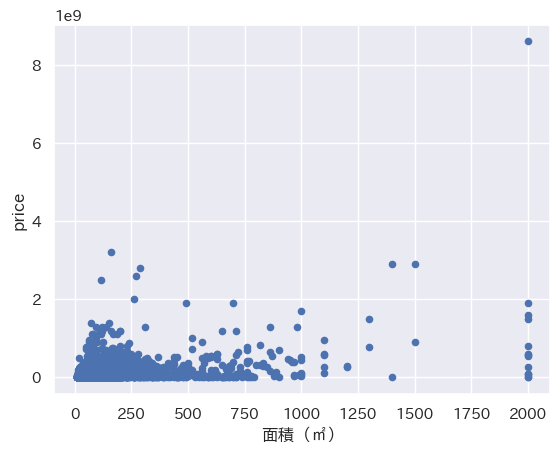

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='面積（㎡）', y='price')

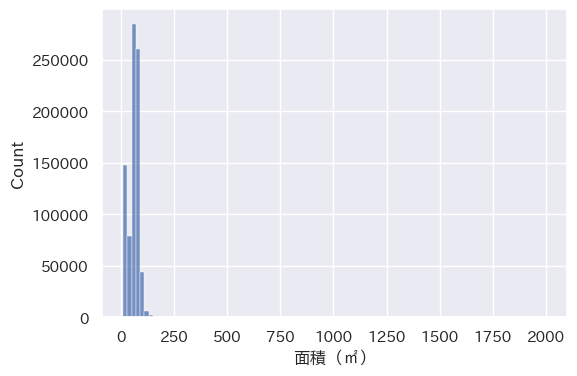

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["面積（㎡）"],kde=False,bins=100)
plt.show()

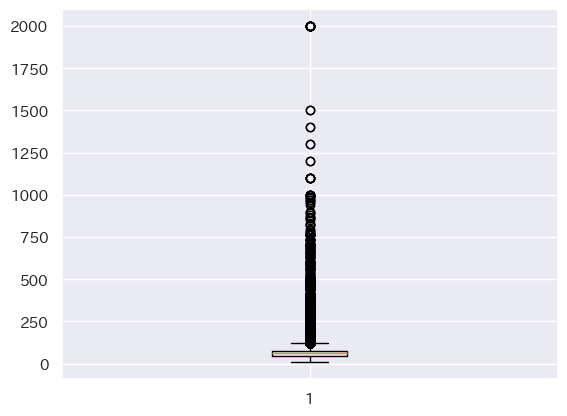

In [ ]:
data1 = feat_df["面積（㎡）"]

fig, ax = plt.subplots()
ax.boxplot(data1)
plt.show()

###2.面積（㎡）_mean

<Axes: xlabel='面積（㎡）_mean', ylabel='price'>

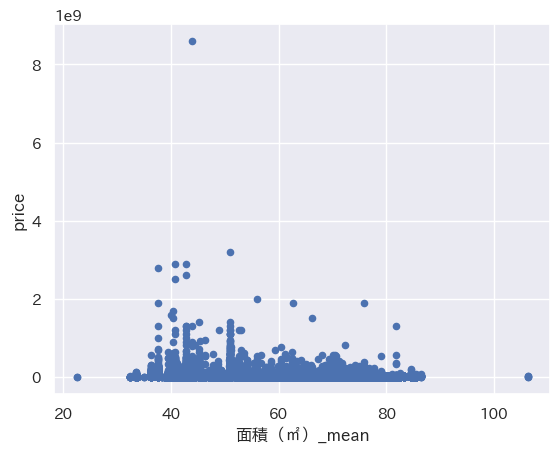

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='面積（㎡）_mean', y='price')

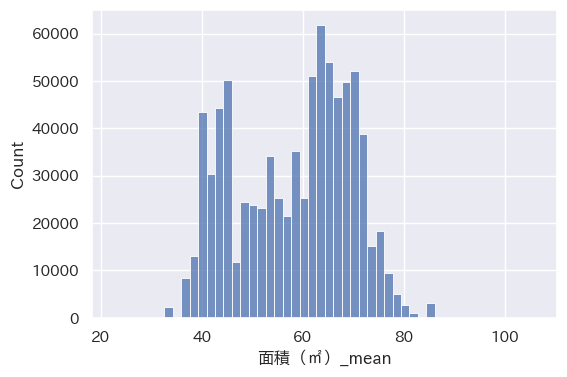

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["面積（㎡）_mean"],kde=False,bins=50)
plt.show()

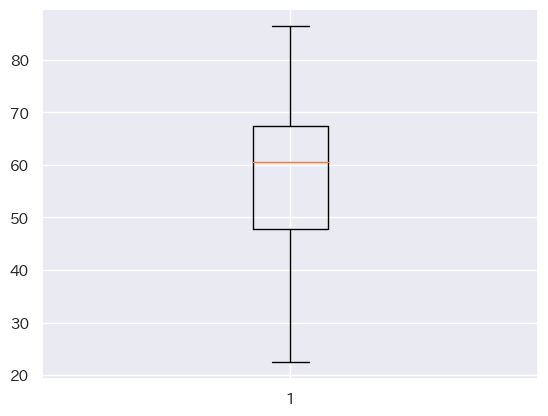

In [ ]:
data2 = feat_df["面積（㎡）_mean"]

fig, ax = plt.subplots()
ax.boxplot(data2,sym="")
plt.show()

###3.面積（㎡）_count

<Axes: xlabel='面積（㎡）_count', ylabel='price'>

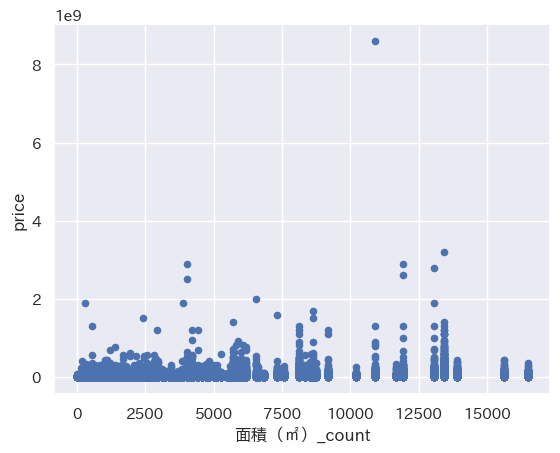

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='面積（㎡）_count', y='price')

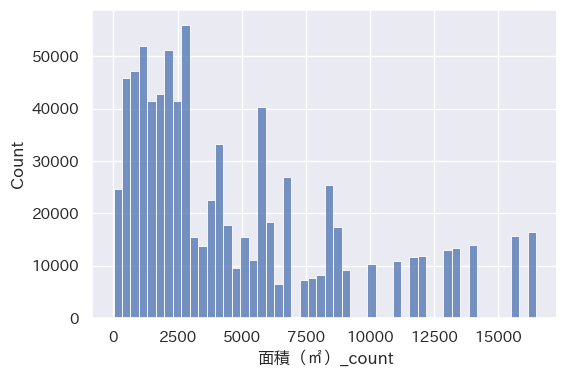

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["面積（㎡）_count"],kde=False,bins=50)
plt.show()

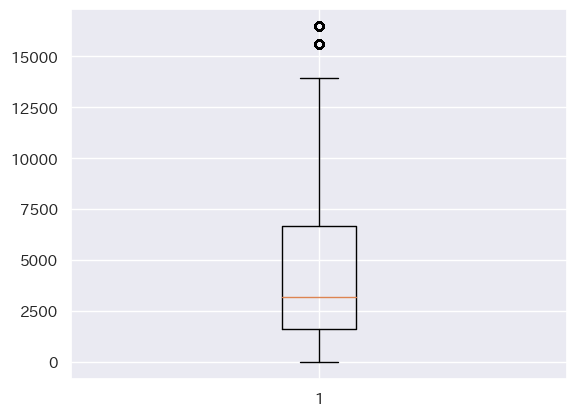

In [ ]:
data3 = feat_df["面積（㎡）_count"]

fig, ax = plt.subplots()
ax.boxplot(data3)
plt.show()

###4.最寄駅：距離（分）_count

<Axes: xlabel='最寄駅：距離（分）_count', ylabel='price'>

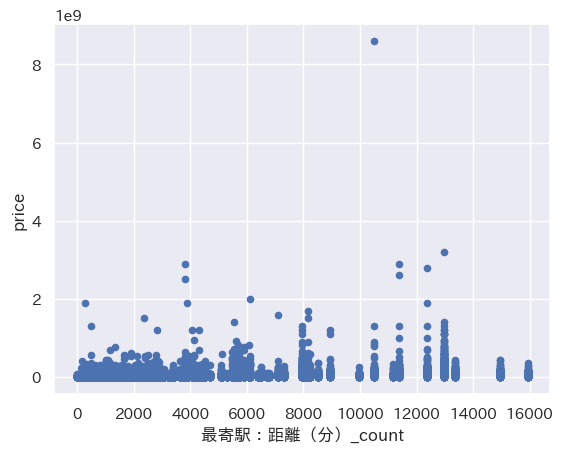

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='最寄駅：距離（分）_count', y='price')

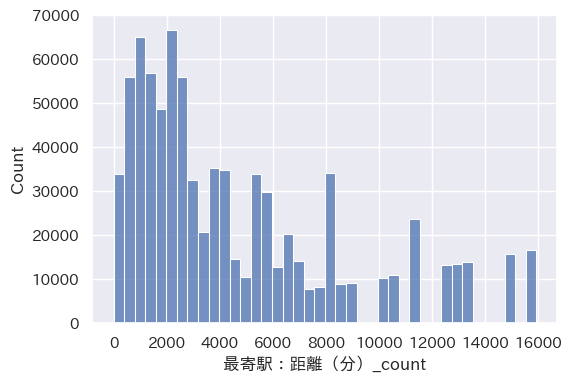

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["最寄駅：距離（分）_count"],kde=False,bins=40)
plt.show()

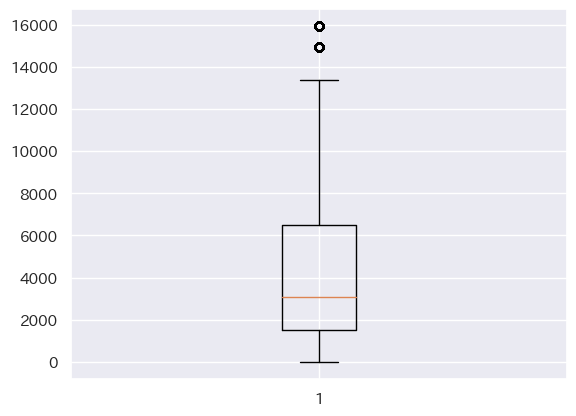

In [ ]:
data4 = feat_df["最寄駅：距離（分）_count"]

fig, ax = plt.subplots()
ax.boxplot(data4)
plt.show()

###5.建築年

<Axes: xlabel='建築年', ylabel='price'>

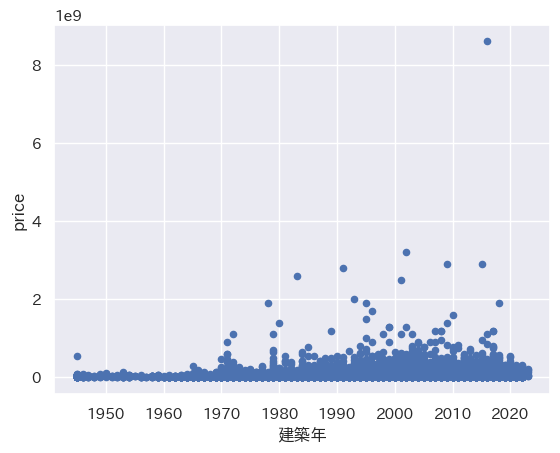

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='建築年', y='price')

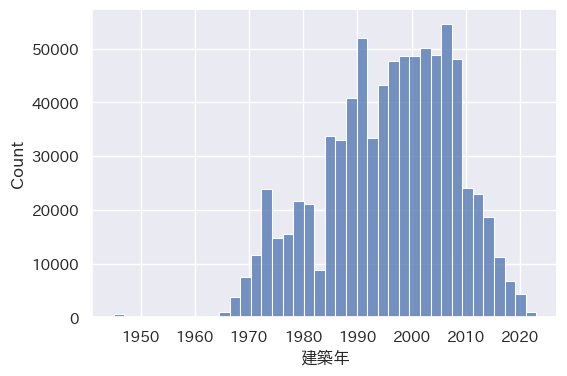

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["建築年"],kde=False,bins=40)
plt.show()

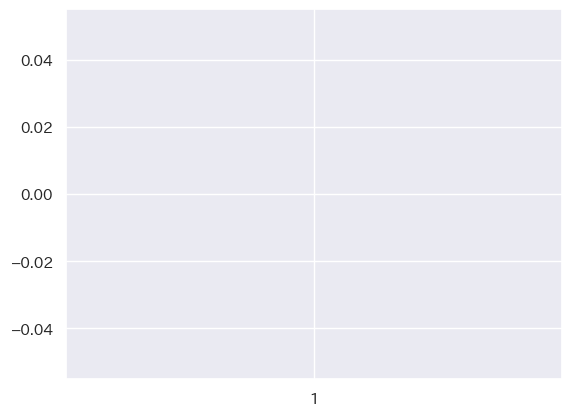

In [ ]:
data5 = feat_df["建築年"]

fig, ax = plt.subplots()
ax.boxplot(data5)
plt.show()

###6.取引時点_何年前

<Axes: xlabel='取引時点_何年前', ylabel='price'>

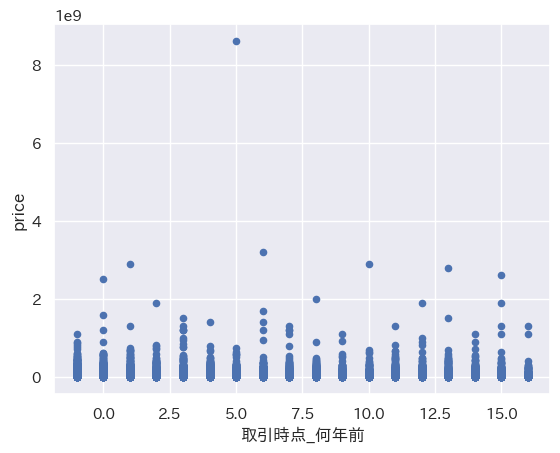

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='取引時点_何年前', y='price')

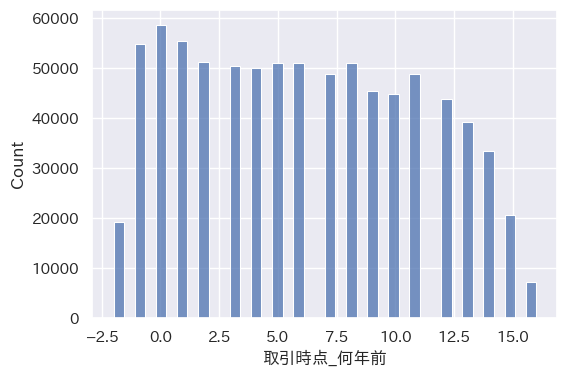

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["取引時点_何年前"],kde=False,bins=40)
plt.show()

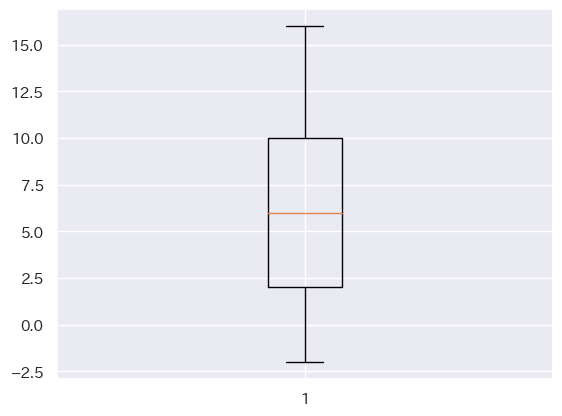

In [ ]:
data6 = feat_df["取引時点_何年前"]

fig, ax = plt.subplots()
ax.boxplot(data6)
plt.show()

###7.取引時点_enc

<Axes: xlabel='取引時点_enc', ylabel='price'>

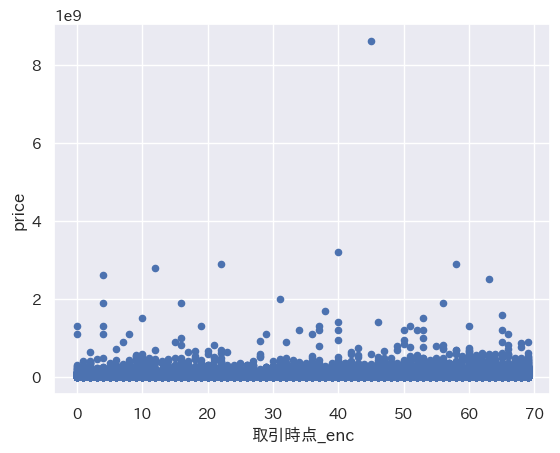

In [ ]:
# 散布図
feat_df.plot(kind='scatter', x='取引時点_enc', y='price')

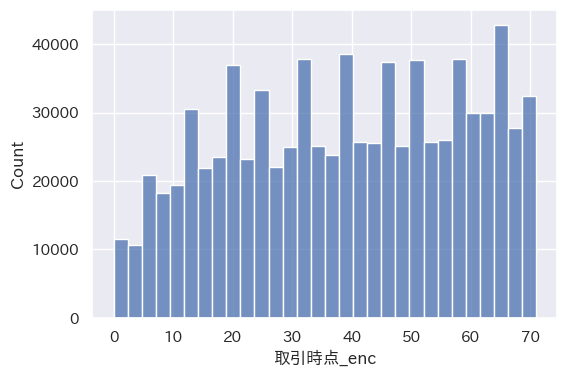

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(feat_df["取引時点_enc"],kde=False,bins=30)
plt.show()

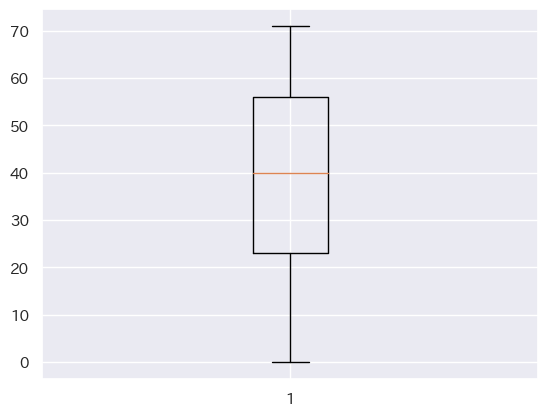

In [ ]:
data7 = feat_df["取引時点_enc"]

fig, ax = plt.subplots()
ax.boxplot(data7)
plt.show()

モデル構築

In [ ]:
feat_df = feat_df.drop(["price"], axis=1)
# priceをドロップ
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等,面積（㎡）容積率（％）_combi,最寄駅：距離（分）_count,最寄駅：距離（分）_mean,最寄駅：距離（分）_min,最寄駅：距離（分）_max,面積（㎡）_count,面積（㎡）_mean,面積（㎡）_min,面積（㎡）_max,建ぺい率（％）_count,建ぺい率（％）_mean,建ぺい率（％）_min,建ぺい率（％）_max,容積率（％）_count,容積率（％）_mean,容積率（％）_min,容積率（％）_max
0,27278791,NaN,90,1988.0,60.0,200.0,7.414973,0,0.0,16,9,204,5989,3837,51,10,7,0,7,1,0,180.0,2656,5.978539,0.0,19.0,2712,62.236357,10,760,2680,71.421642,50.0,80.0,2680,270.149254,200.0,600.0
1,27287304,4.0,25,1987.0,80.0,800.0,6.845098,0,0.0,16,9,200,1910,3416,7,10,20,0,1,2,0,200.0,6492,4.109673,0.0,16.0,6628,43.343392,10,690,6586,79.896751,60.0,80.0,6586,653.112663,100.0,1200.0
2,13378024,13.0,15,2005.0,60.0,300.0,7.322219,0,0.0,16,26,355,651,3870,7,5,7,0,11,2,0,45.0,8929,7.134842,0.0,120.0,9170,40.803162,10,470,9119,68.950543,30.0,80.0,9119,283.524509,60.0,600.0
3,13260464,6.0,45,1994.0,60.0,200.0,7.322219,0,0.0,16,26,198,12109,3840,0,5,7,0,11,2,0,90.0,15933,7.078014,0.0,75.0,16487,41.065082,10,340,16304,67.073724,40.0,80.0,16304,295.132483,80.0,800.0
4,13104441,NaN,65,2003.0,80.0,500.0,7.763428,0,0.0,16,26,117,11726,2452,28,10,7,0,1,2,0,325.0,3822,3.372841,0.0,12.0,4013,40.773735,10,1500,3939,77.735466,60.0,80.0,3939,571.972582,300.0,900.0


feat_df の列ラベル（列名）を取得

In [ ]:
feat_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

## `feat_df` を訓練データ、検証データ、テストデータに分割する

1. `train_df = feat_df.iloc[:val_min_idx, :]`: `feat_df` の最初の行から `val_min_idx` 未満の行までを含む部分を作成し、  
訓練データとして `train_df` に代入。これにより、訓練データは最初から `val_min_idx` 未満の行まで。

2. `val_df = feat_df.iloc[val_min_idx:test_min_idx, :]`: `feat_df` の `val_min_idx` 行から `test_min_idx` 未満の行までを含む部分を作成し、検証データとして `val_df` に代入。これにより、検証データは `val_min_idx` 行から `test_min_idx` 未満の行。

3. `test_df = feat_df.iloc[test_min_idx:, :]`: `feat_df` の `test_min_idx` 行から最後の行までを含む部分を作成し、テストデータとして `test_df` に代入。  
これにより、テストデータは `test_min_idx` 行からデータセットの最後の行まで。

4. `print(train_df.shape, val_df.shape, test_df.shape)`: 各データ形状（行数と列数）を表示

データを訓練、検証、テストの3つのセットに分割し、機械学習モデルの訓練、検証、評価に使用する

In [ ]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(780128, 38) (26868, 38) (19121, 38)


In [ ]:
train_df.isnull().sum()

ID                       0
最寄駅：距離（分）            23223
面積（㎡）                    0
建築年                  22840
建ぺい率（％）              25360
容積率（％）               25360
取引価格（総額）_log             0
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi    25360
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean         247
最寄駅：距離（分）_min          247
最寄駅：距離（分）_max          247
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             8
建ぺい率（％）_min              8
建ぺい率（％）_max              8
容積率（％）_count             0
容積率（％）_mean              8
容積率（％）_min               8
容

In [ ]:
train_df = train_df.dropna()

In [ ]:
train_df.shape

(722783, 38)

In [ ]:
train_df.isnull().sum()

ID                   0
最寄駅：距離（分）            0
面積（㎡）                0
建築年                  0
建ぺい率（％）              0
容積率（％）               0
取引価格（総額）_log         0
取引時点_enc             0
都道府県名_te             0
取引時点_何年前             0
都道府県名                0
市区町村名                0
地区名                  0
最寄駅：名称               0
間取り                  0
建物の構造                0
用途                   0
今後の利用目的              0
都市計画                 0
改装                   0
取引の事情等               0
面積（㎡）容積率（％）_combi    0
最寄駅：距離（分）_count      0
最寄駅：距離（分）_mean       0
最寄駅：距離（分）_min        0
最寄駅：距離（分）_max        0
面積（㎡）_count          0
面積（㎡）_mean           0
面積（㎡）_min            0
面積（㎡）_max            0
建ぺい率（％）_count        0
建ぺい率（％）_mean         0
建ぺい率（％）_min          0
建ぺい率（％）_max          0
容積率（％）_count         0
容積率（％）_mean          0
容積率（％）_min           0
容積率（％）_max           0
dtype: int64

In [ ]:
val_df = val_df.dropna()

In [ ]:
val_df.shape

(25675, 38)

In [ ]:
val_df.isnull().sum()

ID                   0
最寄駅：距離（分）            0
面積（㎡）                0
建築年                  0
建ぺい率（％）              0
容積率（％）               0
取引価格（総額）_log         0
取引時点_enc             0
都道府県名_te             0
取引時点_何年前             0
都道府県名                0
市区町村名                0
地区名                  0
最寄駅：名称               0
間取り                  0
建物の構造                0
用途                   0
今後の利用目的              0
都市計画                 0
改装                   0
取引の事情等               0
面積（㎡）容積率（％）_combi    0
最寄駅：距離（分）_count      0
最寄駅：距離（分）_mean       0
最寄駅：距離（分）_min        0
最寄駅：距離（分）_max        0
面積（㎡）_count          0
面積（㎡）_mean           0
面積（㎡）_min            0
面積（㎡）_max            0
建ぺい率（％）_count        0
建ぺい率（％）_mean         0
建ぺい率（％）_min          0
建ぺい率（％）_max          0
容積率（％）_count         0
容積率（％）_mean          0
容積率（％）_min           0
容積率（％）_max           0
dtype: int64

In [ ]:
test_df.isnull().sum()

ID                       0
最寄駅：距離（分）               18
面積（㎡）                    0
建築年                    578
建ぺい率（％）                385
容積率（％）                 385
取引価格（総額）_log         19121
取引時点_enc                 0
都道府県名_te                 0
取引時点_何年前                 0
都道府県名                    0
市区町村名                    0
地区名                      0
最寄駅：名称                   0
間取り                      0
建物の構造                    0
用途                       0
今後の利用目的                  0
都市計画                     0
改装                       0
取引の事情等                   0
面積（㎡）容積率（％）_combi      385
最寄駅：距離（分）_count          0
最寄駅：距離（分）_mean           5
最寄駅：距離（分）_min            5
最寄駅：距離（分）_max            5
面積（㎡）_count              0
面積（㎡）_mean               0
面積（㎡）_min                0
面積（㎡）_max                0
建ぺい率（％）_count            0
建ぺい率（％）_mean             0
建ぺい率（％）_min              0
建ぺい率（％）_max              0
容積率（％）_count             0
容積率（％）_mean              0
容積率（％）_min               0
容

###LightGBM

In [ ]:
cat_cols = list(le_df.columns) + ["取引時点_enc"]
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [ ]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

####クロスバリデーション（吉田さん）

In [ ]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
valid_score = []
models = []

for fold,(train_indices,valid_indices) in enumerate(kf.split(train_x)):
  print("#fold:",fold)
  X_train, X_valid = train_x.iloc[train_indices], train_x.iloc[valid_indices]
  y_train, y_valid = train_y.iloc[train_indices], train_y.iloc[valid_indices]
  train_data = lgb.Dataset(X_train, y_train)
  val_data = lgb.Dataset(X_valid, y_valid)

  model = lgb.train(
      params,
      train_data,
      categorical_feature = cat_cols,
      valid_names = ["train","valid"],
      valid_sets = [train_data,val_data],
      callbacks = [
          lgb.log_evaluation(100),
      ]
  )

  y_valid_pred = model.predict(X_valid,num_iteration=model.best_iteration)
  score = mean_absolute_error(y_valid,y_valid_pred)
  print("validation score",score)

  models.append(model)

#fold: 0


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's l1: 0.0777324	valid's l1: 0.0807536
[200]	train's l1: 0.0734691	valid's l1: 0.0776302
[300]	train's l1: 0.0715204	valid's l1: 0.0764334
[400]	train's l1: 0.0702347	valid's l1: 0.0758296
[500]	train's l1: 0.0691585	valid's l1: 0.0753642
[600]	train's l1: 0.0684009	valid's l1: 0.075158
[700]	train's l1: 0.0677167	valid's l1: 0.0749881
[800]	train's l1: 0.0671858	valid's l1: 0.0748917
[900]	train's l1: 0.0666207	valid's l1: 0.0747842
[1000]	train's l1: 0.0661159	valid's l1: 0.0747111
[1100]	train's l1: 0.0656643	valid's l1: 0.0746794
[1200]	train's l1: 0.0652605	valid's l1: 0.0746439
[1300]	train's l1: 0.0648407	valid's l1: 0.0746127
[1400]	train's l1: 0.064363	valid's l1: 0.0745215
[1500]	train's l1: 0.06398	valid's l1: 0.0744943
[1600]	train's l1: 0.0636208	valid's l1: 0.0744922
validation score 0.07448162619666028
#fold: 1


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's l1: 0.0781141	valid's l1: 0.0805917
[200]	train's l1: 0.0738131	valid's l1: 0.0774564
[300]	train's l1: 0.0716826	valid's l1: 0.0761229
[400]	train's l1: 0.0704605	valid's l1: 0.0755563
[500]	train's l1: 0.0693513	valid's l1: 0.0751081
[600]	train's l1: 0.068624	valid's l1: 0.0749021
[700]	train's l1: 0.0679037	valid's l1: 0.0746893
[800]	train's l1: 0.0673911	valid's l1: 0.0746355
[900]	train's l1: 0.0668172	valid's l1: 0.0745326
[1000]	train's l1: 0.0662953	valid's l1: 0.0744467
[1100]	train's l1: 0.0657212	valid's l1: 0.0743386
[1200]	train's l1: 0.0653336	valid's l1: 0.0743126
[1300]	train's l1: 0.0649382	valid's l1: 0.074283
[1400]	train's l1: 0.0645189	valid's l1: 0.0742361
[1500]	train's l1: 0.064111	valid's l1: 0.0741838
[1600]	train's l1: 0.0637455	valid's l1: 0.0741872
[1700]	train's l1: 0.0634094	valid's l1: 0.0741718
[1800]	train's l1: 0.0631073	valid's l1: 0.0741739
validation score 0.07416662112267602
#fold: 2


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's l1: 0.0779334	valid's l1: 0.0806024
[200]	train's l1: 0.0736698	valid's l1: 0.0775743
[300]	train's l1: 0.0714867	valid's l1: 0.0762996
[400]	train's l1: 0.070277	valid's l1: 0.0757967
[500]	train's l1: 0.069237	valid's l1: 0.0753877
[600]	train's l1: 0.0685391	valid's l1: 0.0751835
[700]	train's l1: 0.0678933	valid's l1: 0.0750515
[800]	train's l1: 0.0673093	valid's l1: 0.0749136
[900]	train's l1: 0.0666937	valid's l1: 0.0747941
[1000]	train's l1: 0.0661692	valid's l1: 0.0747028
[1100]	train's l1: 0.0656885	valid's l1: 0.0746463
[1200]	train's l1: 0.0652956	valid's l1: 0.0746098
[1300]	train's l1: 0.0649092	valid's l1: 0.0745971
[1400]	train's l1: 0.0644984	valid's l1: 0.0745414
[1500]	train's l1: 0.064132	valid's l1: 0.0745315
[1600]	train's l1: 0.0637792	valid's l1: 0.0745214
[1700]	train's l1: 0.0634564	valid's l1: 0.0745213
validation score 0.07451875839943421
#fold: 3


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's l1: 0.0777339	valid's l1: 0.0811115
[200]	train's l1: 0.073582	valid's l1: 0.0780013
[300]	train's l1: 0.0714604	valid's l1: 0.0766717
[400]	train's l1: 0.0702017	valid's l1: 0.0760423
[500]	train's l1: 0.0691486	valid's l1: 0.0755864
[600]	train's l1: 0.0683686	valid's l1: 0.0753554
[700]	train's l1: 0.0677078	valid's l1: 0.0751907
[800]	train's l1: 0.0671458	valid's l1: 0.0750626
[900]	train's l1: 0.066569	valid's l1: 0.0749538
[1000]	train's l1: 0.0660665	valid's l1: 0.0748858
[1100]	train's l1: 0.0655456	valid's l1: 0.0747842
[1200]	train's l1: 0.0651311	valid's l1: 0.0747494
[1300]	train's l1: 0.0647532	valid's l1: 0.0747148
[1400]	train's l1: 0.0643626	valid's l1: 0.0746913
validation score 0.0746878126445508
#fold: 4


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's l1: 0.0777569	valid's l1: 0.0804058
[200]	train's l1: 0.0735604	valid's l1: 0.0773011
[300]	train's l1: 0.0715434	valid's l1: 0.0760811
[400]	train's l1: 0.0703479	valid's l1: 0.0755472
[500]	train's l1: 0.0692237	valid's l1: 0.0751008
[600]	train's l1: 0.0685301	valid's l1: 0.0749094
[700]	train's l1: 0.0678334	valid's l1: 0.0747259
[800]	train's l1: 0.0672711	valid's l1: 0.0746211
[900]	train's l1: 0.0666925	valid's l1: 0.0745319
[1000]	train's l1: 0.0661773	valid's l1: 0.0744452
[1100]	train's l1: 0.0656673	valid's l1: 0.074363
[1200]	train's l1: 0.0652673	valid's l1: 0.0743471
validation score 0.07434299047457693


In [ ]:
pred_df = pd.DataFrame()

for i, m in enumerate(models):
  test_pred = m.predict(test_x,num_iteration=m.best_iteration)
  pred_df[i] = test_pred

In [ ]:
pred_df["mean"] = pred_df.mean(axis=1)
pred_df

,0,1,2,3,4,mean
0,7.288043,7.337462,7.254515,7.327033,7.306881,7.302787
1,7.389593,7.455278,7.436108,7.393188,7.406536,7.416141
2,7.440022,7.451586,7.408780,7.472515,7.454475,7.445476
3,7.388219,7.382325,7.360152,7.436005,7.415206,7.396381
4,7.229115,7.244905,7.250311,7.265058,7.253319,7.248541
...,...,...,...,...,...,...
19116,7.302540,7.298260,7.290165,7.284246,7.273985,7.289839
19117,7.302540,7.298260,7.290165,7.284246,7.273985,7.289839
19118,7.605315,7.629547,7.603916,7.620402,7.622200,7.616276
19119,6.950660,7.071504,7.105114,7.018881,7.074988,7.044229


In [ ]:
test_df.loc[:,TARGET] = pred_df["mean"].values

In [ ]:
test_df[TARGET] = pred_df["mean"].values

<ipython-input-242-dd0c2bd944b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = pred_df["mean"].values


In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)

####クロスバリデーション

In [ ]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor


# クロスバリデーションの設定
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# 各foldでのスコアを格納するリスト
scores = []


for fold, (train_index, val_index) in enumerate(kf.split(train_x, train_y)):
    print(f"Fold {fold+1}/{num_folds}")

    # トレーニングセットとバリデーションセットを分割
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    # モデルをインスタンス化（必要に応じてパラメータを指定）
    model = RandomForestRegressor()

    # モデルをトレーニング
    model.fit(X_train, y_train)

    # バリデーションセットで予測
    val_pred = model.predict(X_val)

    # バリデーションセットでのスコアを計算し、記録
    fold_score = accuracy_score(y_val, val_pred)
    scores.append(fold_score)
    print(f"Validation Accuracy: {fold_score}")

# クロスバリデーションの平均スコアを計算
mean_score = sum(scores) / len(scores)
print(f"Mean Validation Accuracy: {mean_score}")

# 最終的なモデルをトレーニングセット全体でトレーニング
final_model = YourModel()
final_model.fit(train_x, train_y)

# テストセットでの性能を評価
test_pred = final_model.predict(test_x)
test_score = accuracy_score(test_y, test_pred)
print(f"Test Accuracy: {test_score}")


Fold 1/5


ValueError: continuous is not supported

特徴量として使用する列を選択するための処理
1. `rm_cols`: 除外する列のリスト。これらの列は特徴量として使用されず、除外。
2. `ID`および`TARGET`: 特徴量として使用しないID列とターゲット変数の列。

上記の条件に基づいて、訓練データから選択された特徴量の列名を`feat_cols`に格納。

`train_df`の列のうち、`rm_cols`に含まれていないかつ`ID`や`TARGET`でない列のみを選択。これらの列は、`feat_cols`に格納。

変数として使用する列を選択する処理

1. `le_df.columns`:  `le_df` の列名を取得。
2. `['取引時点_enc']`: '取引時点_enc'リストを追加。特徴量の一部として追加。

リスト `cat_cols` が生成

ラベルエンコーディングされたカテゴリカル変数の列名を`le_df.columns`から取得し、それに'取引時点_enc'という列名を追加。列名は`cat_cols`に格納。

In [ ]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [ ]:
train_df.columns

Index(['ID', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）', '取引価格（総額）_log',
       '取引時点_enc', '都道府県名_te', '取引時点_何年前', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '間取り', '建物の構造', '用途', '今後の利用目的', '都市計画', '改装', '取引の事情等',
       '面積（㎡）容積率（％）_combi', '最寄駅：距離（分）_count', '最寄駅：距離（分）_mean',
       '最寄駅：距離（分）_min', '最寄駅：距離（分）_max', '面積（㎡）_count', '面積（㎡）_mean',
       '面積（㎡）_min', '面積（㎡）_max', '建ぺい率（％）_count', '建ぺい率（％）_mean',
       '建ぺい率（％）_min', '建ぺい率（％）_max', '容積率（％）_count', '容積率（％）_mean',
       '容積率（％）_min', '容積率（％）_max'],
      dtype='object')

訓練データ、検証データ、テストデータのターゲット変数を選択

1. `train_df[feat_cols]`: `train_df` 特徴量の列を `feat_cols` に指定された列のみを抽出。これにより、訓練データの特徴量を表す `train_x` が作成。
2. `train_df[TARGET]`: `train_df` ターゲット変数の列を抽出。これにより、訓練データのターゲット変数を表す `train_y` が作成。
3. `val_df[feat_cols]`: 検証データの `val_x` を作成。
4. `val_df[TARGET]`: 検証データのターゲット変数を表す `val_y` を作成。
5. `test_df[feat_cols]`: テストデータの `test_x` を作成。
6. `test_df[TARGET]`: テストデータのターゲット変数を表す `test_y` を作成。

それぞれのデータセットにおける特徴量とターゲット変数が取得

In [ ]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [ ]:
train_x.isnull().sum()

LightGBMを使用して回帰モデルをトレーニングし、検証データでの性能を評価する処理

1. `params`: LightGBMのモデルのハイパーパラメータを指定。目的関数、評価指標、木の深さなど
2. `train_data`と`val_data`: LightGBMのデータセットオブジェクトを作成。これには、訓練データと検証データの特徴量とターゲット変数。
3. `lgb.train()`: LightGBMモデルをトレーニング。指定されたハイパーパラメータとデータセットを使用してモデルをトレーニングし、検証データでの性能を評価。
4. `val_pred`: 検証データに対する予測を取得。
5. `score`: 検証データでの平均絶対誤差（MAE）を計算。
6. `pred_df`: 予測結果と実際の値を含むDataFrameを作成。
7. `feature_imp`: 各特徴量の重要度を計算し、重要度の高い順に並べを作成。
8. 最後に、スコアを表示。

LightGBMモデルのトレーニング、検証、評価

In [ ]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data,
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data],
    callbacks=[
        lgb.log_evaluation(100),
    ]
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

重要度を可視化し、画像ファイルとして保存する処理

具体的には：

1. `lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')`: 重要度をプロット。`figsize`でプロットのサイズ、`max_num_features`最大数、`importance_type`で重要度の種類を指定。

2. `plt.tight_layout()`: 表示する前に、プロット内の要素が重ならないように整え。

3. `plt.savefig(BASE_PATH + 'output/feature_importance.png')`: プロットを画像ファイルとして保存。`BASE_PATH + 'output/feature_importance.png'`に指定されたパスに画像が保存。

4. `plt.show()`: 保存した画像を表示。

5. `plt.close()`: プロットを閉。

LightGBMモデルの特徴量の重要度が可視化され、画像ファイルとして保存。

In [ ]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

## 推論

トレーニングされたLightGBMモデルを使用して、テストデータの予測。

1. `model.predict(test_x, num_iteration=model.best_iteration)`: テストデータ `test_x` に対する予測。`num_iteration=model.best_iteration`は、最適なイテレーション回数での予測を行うことを指定。テストデータの予測値が取得。

トレーニングされたモデルを使用してテストデータの予測。

In [ ]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

テストデータの予測結果をテストデータのDataFrameに追加。

`test_pred`によって予測された変数（ターゲット）の値を、テストデータのDataFrame `test_df` に新しい列として追加。

テストデータに対する予測結果が、実際の目的変数の値とともに保持。

In [ ]:
test_df[TARGET] = test_pred

テストデータの予測結果を含むDataFrame test_df と、  
提出に必要なID列を含むDataFrame sub_df をマージし、  
CSVファイルとして出力する処理。

`pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')`: sub_df のID列と、test_df のID列と目的変数列を含むDataFrameを、ID列をキーにして結合。DataFrameが作成。

`sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)`: 作成した提出用のDataFrameをCSVファイルとして保存。  
`BASE_PATH + 'output/test_submission.csv'`に指定されたパスにCSVファイルが保存。  
`index=False`を指定することで、行のインデックスは保存されない。

提出用のCSVファイルが出力

In [ ]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)